# Startup Success Probability 
```
Determining the success probabilty of a startup project using determining factors such as target amount, backer count, project member count, and etc. This is to help startup teams to reassess their strategies especially in crowdfunding as well as take care of the important variables that may define the project's success.
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score, roc_auc_score, accuracy_score, f1_score, recall_score, precision_recall_curve, log_loss, precision_score, auc, roc_curve
from scipy.stats.mstats import winsorize
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import pickle

df = pd.read_csv('turkish_crowdfunding_startups/turkishCF.csv', delimiter=';')

df.head()

,id,platform_adi,kitle_fonlamasi_turu,kategori,fon_sekli,proje_adi,proje_sahibi,proje_sahibi_cinsiyet,kac_proje_destekledi,kac_projeye_abone,...,sosyal_medya,sm_sayisi,sm_takipci,etiket_sayisi,icerik_kelime_sayisi,proje_aciklamasi,hedef_miktari,toplanan_tutar,destek_orani,basari_durumu
0,1,fongogo,ödül,diğer,ya hep ya hiç,Gerçek Gizlidir Filmleri,Lob Ekibi,belirsiz,1,0,...,var,3,274,0,301,Türkiye’de ilk kez her aşaması ‘online’ olarak...,40000,54410,136%,başarılı
1,2,fongogo,ödül,diğer,ya hep ya hiç,Fongogo - Hayat Bulsun!,Fongogo Team,belirsiz,3,0,...,var,3,5634,0,167,"Fongogo ekibi olarak büyümek, daha geniş kitle...",50000,50110,100%,başarılı
2,3,fongogo,ödül,diğer,ya hep ya hiç,"PAYLAŞIMIN, SEVGİNİN VE ÇOCUKLARIN İYİLİK EVİ ...",SİNEM CAN,kadın,0,0,...,var,2,510,4,413,Çocuklara her şeyin ücretsiz olduğu iyilik evi...,47000,47850,101%,başarılı
3,4,fongogo,ödül,diğer,ya hep ya hiç,Türk Kadının 100.yıl Seyri,Deniz Tutkusu Seyirde,kadın,0,0,...,var,2,3338,5,287,‘Sözde değil Özde İzindeyiz ‘ sloganıyla Atatü...,35000,35450,101%,başarılı
4,5,fongogo,ödül,diğer,ya hep ya hiç,Doğadaki Çocuk,Seren Kutadgu,kadın,2,0,...,var,1,144,3,571,İstanbul'daki çocuk yuvalarında yaşayan dezava...,30000,31250,104%,başarılı


In [2]:
df.columns

Index(['id', 'platform_adi', 'kitle_fonlamasi_turu', 'kategori', 'fon_sekli',
       'proje_adi', 'proje_sahibi', 'proje_sahibi_cinsiyet',
       'kac_proje_destekledi', 'kac_projeye_abone', 'kac_projenin_sahibi',
       'kac_proje_takiminda', 'konum', 'bolge', 'yil', 'proje_baslama_tarihi',
       'proje_bitis_tarihi', 'gun_sayisi', 'tanitim_videosu', 'video_uzunlugu',
       'gorsel_sayisi', 'sss', 'guncellemeler', 'yorumlar', 'destekci_sayisi',
       'odul_sayisi', 'ekip_kisi_sayisi', 'web_sitesi', 'sosyal_medya',
       'sm_sayisi', 'sm_takipci', 'etiket_sayisi', 'icerik_kelime_sayisi',
       'proje_aciklamasi', 'hedef_miktari', 'toplanan_tutar', 'destek_orani',
       'basari_durumu'],
      dtype='object')

In [3]:
df.columns = ['id', 'platform_name', 'mass_funding_type', 'project_category', 'funding_method',
       'project_name', 'project_owner', 'project_owner_gender',
       'project_supported', 'subscribed_projects', 'number_of_projects_owned',
       'number_of_teams', 'owner_location', 'project_region', 'launch_year', 'project_start_date',
       'project_end_date', 'project_duration', 'promo_video', 'promo_video_length',
       'image_count', 'faq', 'updates', 'comments', 'backer_count',
       'reward_count', 'project_member_count', 'website', 'social_media',
       'social_media_count', 'social_media_followers', 'total_tags', 'project_description_length',
       'project_description', 'target_amount', 'collected_amount', 'target_amount_percentage',
       'success_status']
df.head()

,id,platform_name,mass_funding_type,project_category,funding_method,project_name,project_owner,project_owner_gender,project_supported,subscribed_projects,...,social_media,social_media_count,social_media_followers,total_tags,project_description_length,project_description,target_amount,collected_amount,target_amount_percentage,success_status
0,1,fongogo,ödül,diğer,ya hep ya hiç,Gerçek Gizlidir Filmleri,Lob Ekibi,belirsiz,1,0,...,var,3,274,0,301,Türkiye’de ilk kez her aşaması ‘online’ olarak...,40000,54410,136%,başarılı
1,2,fongogo,ödül,diğer,ya hep ya hiç,Fongogo - Hayat Bulsun!,Fongogo Team,belirsiz,3,0,...,var,3,5634,0,167,"Fongogo ekibi olarak büyümek, daha geniş kitle...",50000,50110,100%,başarılı
2,3,fongogo,ödül,diğer,ya hep ya hiç,"PAYLAŞIMIN, SEVGİNİN VE ÇOCUKLARIN İYİLİK EVİ ...",SİNEM CAN,kadın,0,0,...,var,2,510,4,413,Çocuklara her şeyin ücretsiz olduğu iyilik evi...,47000,47850,101%,başarılı
3,4,fongogo,ödül,diğer,ya hep ya hiç,Türk Kadının 100.yıl Seyri,Deniz Tutkusu Seyirde,kadın,0,0,...,var,2,3338,5,287,‘Sözde değil Özde İzindeyiz ‘ sloganıyla Atatü...,35000,35450,101%,başarılı
4,5,fongogo,ödül,diğer,ya hep ya hiç,Doğadaki Çocuk,Seren Kutadgu,kadın,2,0,...,var,1,144,3,571,İstanbul'daki çocuk yuvalarında yaşayan dezava...,30000,31250,104%,başarılı


## Data Preparation

Before everything, I want to make the text lowercase for uniformity

In [4]:
for cols in df.select_dtypes('object').columns:
    df[cols] = df[cols].str.lower()
df.head()

,id,platform_name,mass_funding_type,project_category,funding_method,project_name,project_owner,project_owner_gender,project_supported,subscribed_projects,...,social_media,social_media_count,social_media_followers,total_tags,project_description_length,project_description,target_amount,collected_amount,target_amount_percentage,success_status
0,1,fongogo,ödül,diğer,ya hep ya hiç,gerçek gizlidir filmleri,lob ekibi,belirsiz,1,0,...,var,3,274,0,301,türkiye’de ilk kez her aşaması ‘online’ olarak...,40000,54410,136%,başarılı
1,2,fongogo,ödül,diğer,ya hep ya hiç,fongogo - hayat bulsun!,fongogo team,belirsiz,3,0,...,var,3,5634,0,167,"fongogo ekibi olarak büyümek, daha geniş kitle...",50000,50110,100%,başarılı
2,3,fongogo,ödül,diğer,ya hep ya hiç,"paylaşimin, sevgi̇ni̇n ve çocuklarin i̇yi̇li̇k...",si̇nem can,kadın,0,0,...,var,2,510,4,413,çocuklara her şeyin ücretsiz olduğu iyilik evi...,47000,47850,101%,başarılı
3,4,fongogo,ödül,diğer,ya hep ya hiç,türk kadının 100.yıl seyri,deniz tutkusu seyirde,kadın,0,0,...,var,2,3338,5,287,‘sözde değil özde i̇zindeyiz ‘ sloganıyla atat...,35000,35450,101%,başarılı
4,5,fongogo,ödül,diğer,ya hep ya hiç,doğadaki çocuk,seren kutadgu,kadın,2,0,...,var,1,144,3,571,i̇stanbul'daki çocuk yuvalarında yaşayan dezav...,30000,31250,104%,başarılı


Now, I want to check the value counts for each categorical column

In [5]:
df.dtypes

id                             int64
platform_name                 object
mass_funding_type             object
project_category              object
funding_method                object
project_name                  object
project_owner                 object
project_owner_gender          object
project_supported              int64
subscribed_projects            int64
number_of_projects_owned       int64
number_of_teams                int64
owner_location                object
project_region                object
launch_year                    int64
project_start_date            object
project_end_date              object
project_duration               int64
promo_video                   object
promo_video_length             int64
image_count                    int64
faq                            int64
updates                        int64
comments                       int64
backer_count                   int64
reward_count                   int64
project_member_count           int64
w

In [6]:
# for col in df.select_dtypes('object').columns:
#     print(df[col].value_counts())
#     print('\n\n')

There are three columns where the value is *var* or *yok*(yes or no). I want to convert these columns into a binary value.

In [7]:
binary_cols = ['promo_video', 'website', 'social_media']

for col in binary_cols:
    df[col] = df[col].map({'var':1, 'yok':0})
df[binary_cols].head()

,promo_video,website,social_media
0,1,0,1
1,0,0,1
2,1,1,1
3,1,1,1
4,1,0,1


I also want to deal with other columns with only 2 categories to make it easier to read the data later on during the EDA.

In [8]:
# funding method
df['funding_method'] = df['funding_method'].map({'ya hep ya hiç': 'all-or-nothing', 'hepsi kalsın': 'keep-it-all'})

# funding type
df['mass_funding_type'] = df['mass_funding_type'].map({'ödül': 'prize', 'bağış': 'donation'})

# success status
df['success_status'] = df['success_status'].map({'başarısız': 0, 'başarılı': 1})

While on it, I'll change the category as well

In [9]:
# project category
df['project_category'] = df['project_category'].map({
    'film-video-fotoğraf': 'film-video-photography',
    'teknoloji': 'technology',
    'kültür-sanat': 'culture-art',
    'eğitim': 'education',
    'diğer': 'other',
    'çevre': 'environment',
    'müzik': 'music',
    'sağlık-güzellik': 'health-beauty',
    'tasarım': 'design',
    'yayıncılık': 'publishing',
    'gıda-yeme-içme': 'food-eating-drinking',
    'spor': 'sports',
    'hayvanlar': 'animals',
    'moda': 'fashion',
    'sosyal sorumluluk': 'social_responsibility',
    'dans-performans': 'dance-performance',
    'turizm': 'tourism',
})

Finally, I want to convert the target_amount_percentage to numeric.

In [10]:
df['target_amount_percentage'] = df['target_amount_percentage'].str.rstrip('%').astype(float)
df['target_amount_percentage'] = df['target_amount_percentage'] / 100

df.head().T

,0,1,2,3,4
id,1,2,3,4,5
platform_name,fongogo,fongogo,fongogo,fongogo,fongogo
mass_funding_type,prize,prize,prize,prize,prize
project_category,other,other,other,other,other
funding_method,all-or-nothing,all-or-nothing,all-or-nothing,all-or-nothing,all-or-nothing
project_name,gerçek gizlidir filmleri,fongogo - hayat bulsun!,"paylaşimin, sevgi̇ni̇n ve çocuklarin i̇yi̇li̇k...",türk kadının 100.yıl seyri,doğadaki çocuk
project_owner,lob ekibi,fongogo team,si̇nem can,deniz tutkusu seyirde,seren kutadgu
project_owner_gender,belirsiz,belirsiz,kadın,kadın,kadın
project_supported,1,3,0,0,2
subscribed_projects,0,0,0,0,0


### Dropping columns

I will be dropping columns that I won't use for this project due to being irrelevant

In [11]:
del df['project_description_length']
del df['project_description']
del df['id']

### Checking missing values

In [12]:
df.isnull().any()

platform_name               False
mass_funding_type           False
project_category            False
funding_method              False
project_name                False
project_owner               False
project_owner_gender        False
project_supported           False
subscribed_projects         False
number_of_projects_owned    False
number_of_teams             False
owner_location              False
project_region               True
launch_year                 False
project_start_date           True
project_end_date             True
project_duration            False
promo_video                 False
promo_video_length          False
image_count                 False
faq                         False
updates                     False
comments                    False
backer_count                False
reward_count                False
project_member_count        False
website                     False
social_media                False
social_media_count          False
social_media_f

Since there is almost no need for project start date and end date as we're already given the project duration, we can simply drop these columns. I'll also simply ignore project_region by dropping the row.

In [13]:
df.isnull().sum()

platform_name                 0
mass_funding_type             0
project_category              0
funding_method                0
project_name                  0
project_owner                 0
project_owner_gender          0
project_supported             0
subscribed_projects           0
number_of_projects_owned      0
number_of_teams               0
owner_location                0
project_region                1
launch_year                   0
project_start_date          611
project_end_date            553
project_duration              0
promo_video                   0
promo_video_length            0
image_count                   0
faq                           0
updates                       0
comments                      0
backer_count                  0
reward_count                  0
project_member_count          0
website                       0
social_media                  0
social_media_count            0
social_media_followers        0
total_tags                    0
target_a

In [14]:
index_to_drop = df[pd.isnull(df.project_region)].index

df.drop(index_to_drop, inplace=True)
pd.isnull(df.project_region).any()

np.False_

Now, the target variable here is the succes status. I'll have to explore it to get an understanding on what I'm dealing with.

### Data Splitting

In [15]:
target_value = df['success_status'].values

df_full_train, df_test, y_full_train, y_test = train_test_split(df, target_value, test_size=0.2, random_state=42)

df_full_train.reset_index(inplace=True, drop=True)

## Exploratory Data Analysis

### Target Feature

In [16]:
df_full_train['success_status'].value_counts()

success_status
0    1008
1     293
Name: count, dtype: int64

In [17]:
df_full_train['success_status'].value_counts(normalize=True)

success_status
0    0.774789
1    0.225211
Name: proportion, dtype: float64

In [18]:
global_success_rate = df_full_train['success_status'].mean()
global_success_rate.round(2)

np.float64(0.23)

I want to know if not reaching the *target_amount* ends up in an unsuccesful project

In [20]:
# reached target amount and successful
print(f'Percentage of startups that reached the target amount and was successful: {len(df_full_train.query("collected_amount >= target_amount and success_status == 1")) / len(df_full_train) * 100}%')

# didn't reach target amount but still successful
print(f'Number of startups that did not reach the target amount but still successful: {len(df_full_train.query("collected_amount < target_amount and success_status == 1"))}')

# reached target amount yet still unsuccessful
print(f'Number of startups that reached the target amount but was still unsuccessful: {len(df_full_train.query("collected_amount >= target_amount and success_status == 0"))}')

Percentage of startups that reached the target amount and was successful: 22.444273635664874%
Number of startups that did not reach the target amount but still successful: 1
Number of startups that reached the target amount but was still unsuccessful: 1


It seems that it is more likely for startup projects to be successful if they reached the target amount in crowdfunding. There is only one instance from this set of data where the startup reached the desired amount of funds from crowdfunding but failed.

In [21]:
df_full_train.describe().T

,count,mean,std,min,25%,50%,75%,max
project_supported,1301.0,0.386626,2.073742,0.0,0.0,0.00,0.00,31.0
subscribed_projects,1301.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0
number_of_projects_owned,1301.0,1.158340,0.681278,1.0,1.0,1.00,1.00,7.0
number_of_teams,1301.0,0.057648,0.258213,0.0,0.0,0.00,0.00,4.0
launch_year,1301.0,2018.069946,2.061485,2011.0,2017.0,2019.00,2020.00,2021.0
project_duration,1301.0,52.171407,15.109008,0.0,45.0,60.00,60.00,118.0
promo_video,1301.0,0.572636,0.494886,0.0,0.0,1.00,1.00,1.0
promo_video_length,1301.0,66.774020,109.261611,0.0,0.0,45.00,97.00,1651.0
image_count,1301.0,4.873943,5.629000,0.0,1.0,3.00,7.00,57.0
faq,1301.0,0.201384,1.446810,0.0,0.0,0.00,0.00,30.0


##### Key Informations from the table above
- The startup are from dates 2011 to 2021.
- About 22.5% among 1302 startups were successful.
- On average, startups are not able to reach the target amount.

### Numerical Variables

In [22]:
numerical_cols = ['number_of_teams', 'project_duration', 'promo_video_length', 'image_count', 'backer_count', 
                  'reward_count', 'project_member_count', 'social_media_count', 'social_media_followers',
                  'target_amount', 'collected_amount', 'target_amount_percentage']

#### Correlation between features

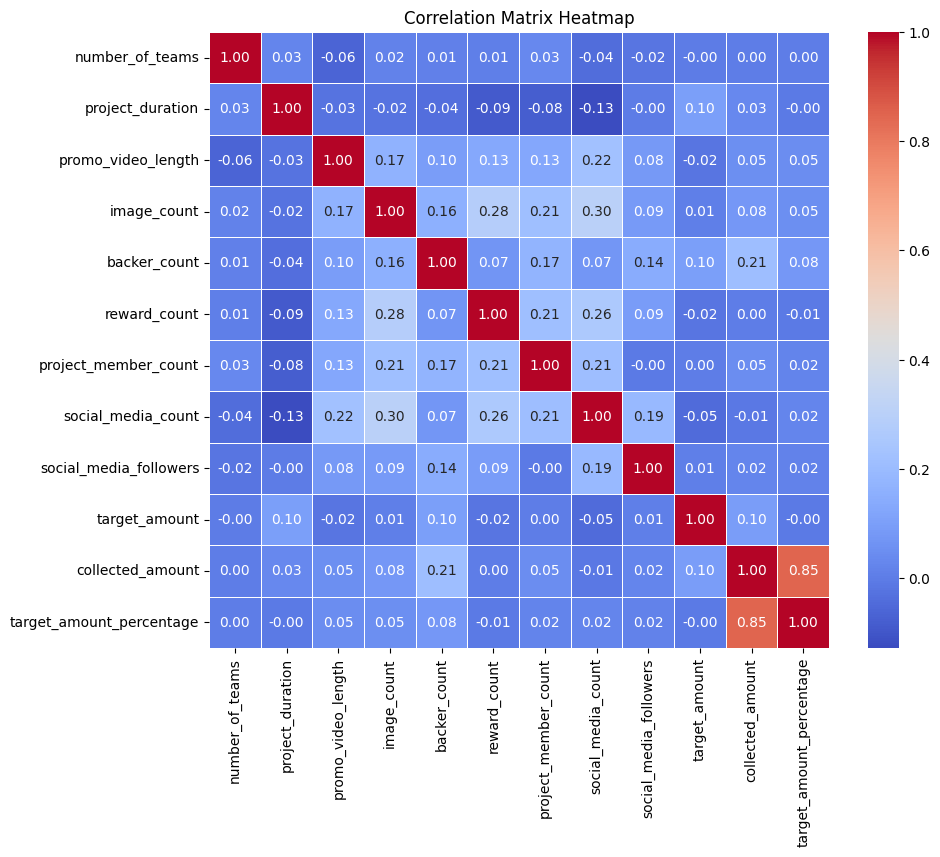

In [23]:
correlation_matrix = df_full_train[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix Heatmap")
plt.show()

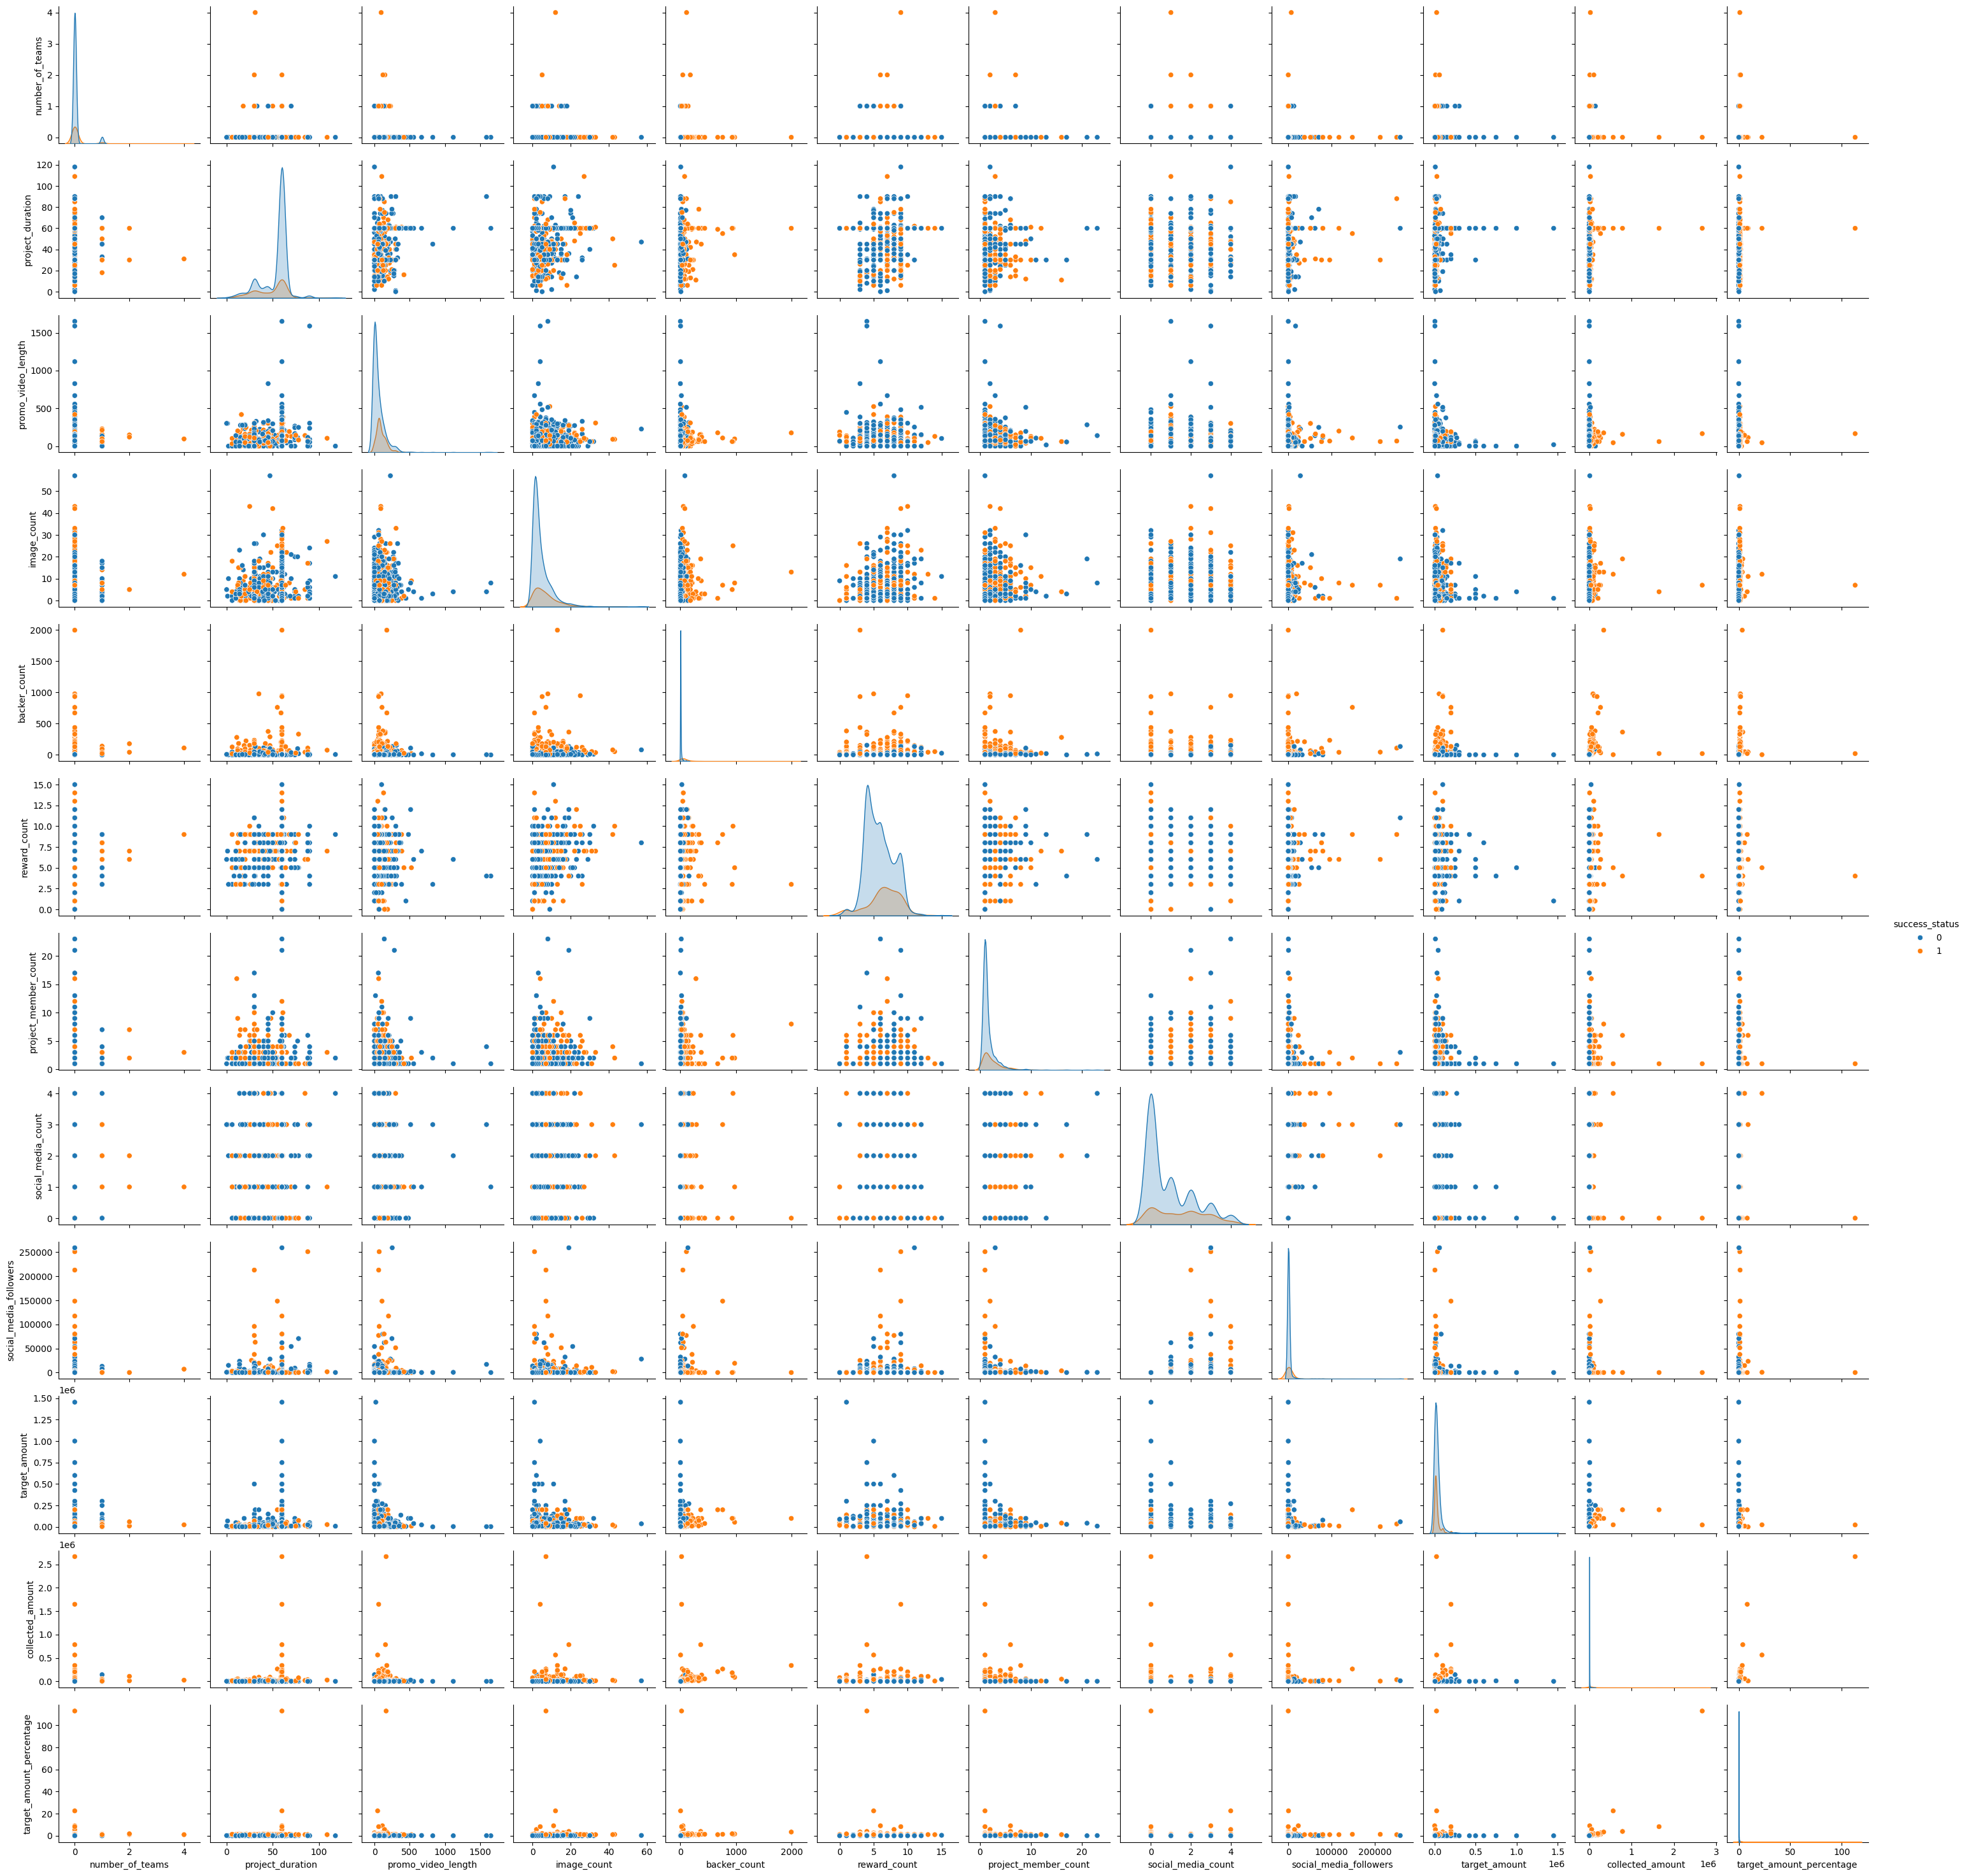

In [23]:
sns.pairplot(df_full_train, hue='success_status', vars=numerical_cols, height=2.5)
plt.show()

There are no strong correlations between the numerical variables.

Now, I'll try to observe the relationship of some of the numerical variables with the success of the project.

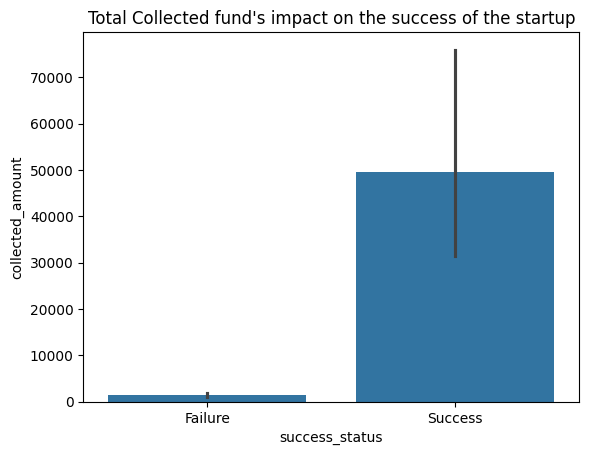

In [24]:
project_status = df_full_train['success_status'].map({1:'Success', 0:'Failure'})

sns.barplot(x=project_status, y=df_full_train['collected_amount']);
plt.title("Total Collected fund's impact on the success of the startup");

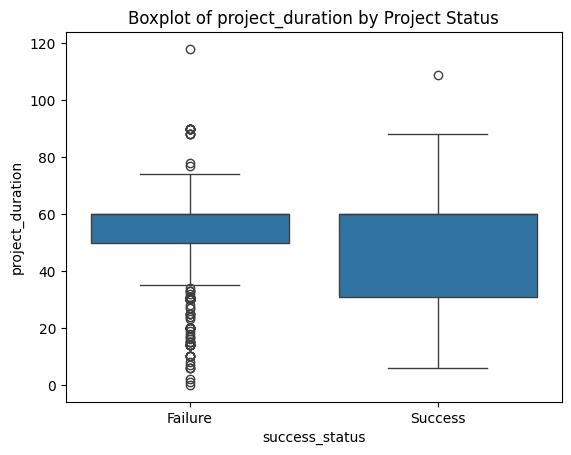

In [25]:
sns.boxplot(x=project_status, y=df_full_train['project_duration']);
plt.title(f'Boxplot of project_duration by Project Status')
plt.show()

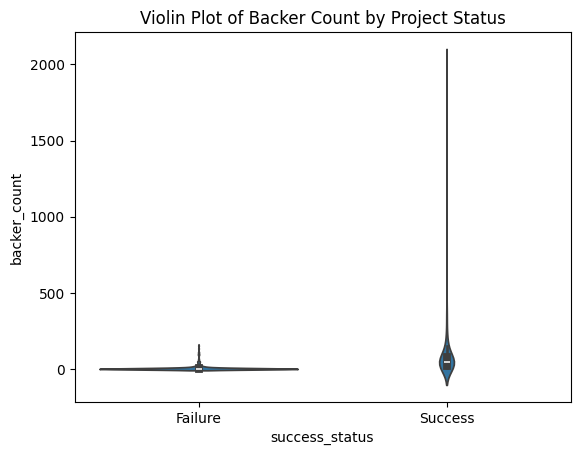

In [26]:
sns.violinplot(x=project_status, y=df_full_train['backer_count']);
plt.title(f'Violin Plot of Backer Count by Project Status')
plt.show()

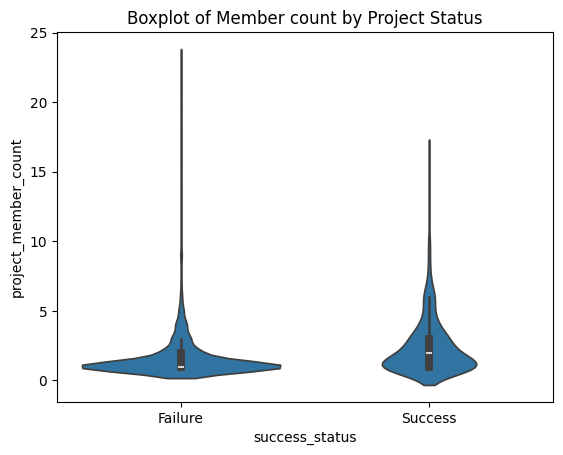

In [27]:
sns.violinplot(x=project_status, y=df_full_train['project_member_count']);
plt.title(f'Boxplot of Member count by Project Status')
plt.show()

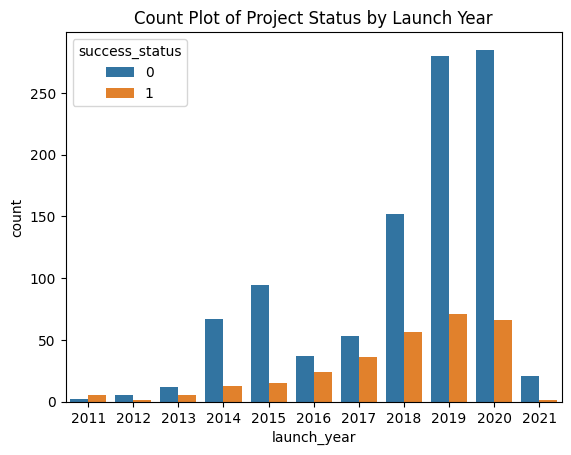

In [28]:
sns.countplot(x='launch_year', hue='success_status', data=df_full_train)
plt.title('Count Plot of Project Status by Launch Year')
plt.show()

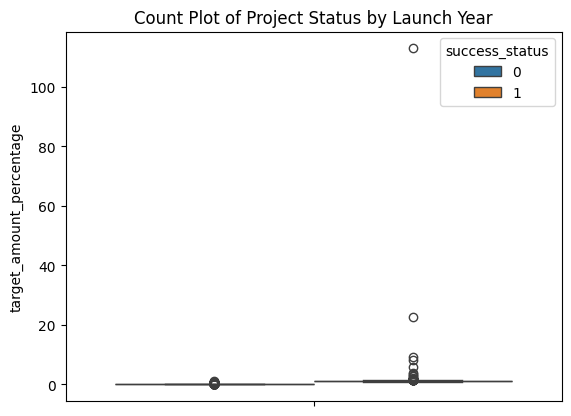

In [29]:
sns.boxplot(y='target_amount_percentage', hue='success_status', data=df_full_train)
plt.title('Count Plot of Project Status by Launch Year')
plt.show()

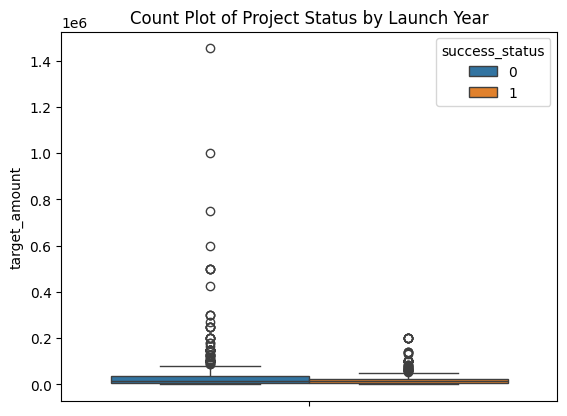

In [30]:
sns.boxplot(y='target_amount', hue='success_status', data=df)
plt.title('Count Plot of Project Status by Launch Year')
plt.show()

#### Correlation with Target

In [31]:
df_full_train[numerical_cols].corrwith(df_full_train.success_status)

number_of_teams             0.064938
project_duration           -0.154147
promo_video_length          0.143915
image_count                 0.190630
backer_count                0.390089
reward_count                0.117745
project_member_count        0.185701
social_media_count          0.195004
social_media_followers      0.130372
target_amount              -0.042276
collected_amount            0.214162
target_amount_percentage    0.206677
dtype: float64

#### Mutual Info Classif

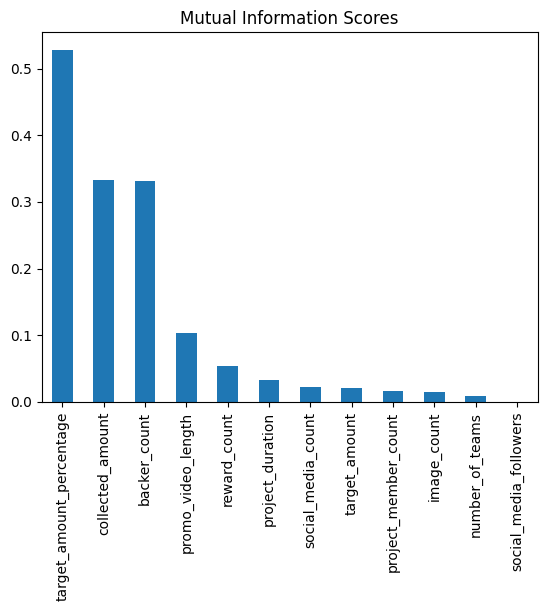

In [32]:
# mutual information
mi = mutual_info_classif(df_full_train[numerical_cols], df_full_train['success_status'])
mi_series = pd.Series(mi, index=numerical_cols)
mi_series.sort_values(ascending=False).plot(kind='bar')
plt.title('Mutual Information Scores')
plt.show()

#### Outliers

In [33]:
Q1 = df_full_train['target_amount_percentage'].quantile(0.25)
Q3 = df_full_train['target_amount_percentage'].quantile(0.75)
IQR = Q3 - Q1

outliers = df_full_train[(df_full_train['target_amount_percentage'] < (Q1 - 1.5 * IQR)) | (df_full_train['target_amount_percentage'] > (Q3 + 1.5 * IQR))]
print(f'Number of Outliers: {len(outliers)}')
print(outliers.head(1).T)
print(f'\nSuccess Rate of outliers in collected_amount: {np.round(outliers['success_status'].mean() * 100, 3)}%')

Number of Outliers: 293
                                               8
platform_name                           crowdfon
mass_funding_type                          prize
project_category          film-video-photography
funding_method                    all-or-nothing
project_name                    kısa film projem
project_owner                         orhan kara
project_owner_gender                       erkek
project_supported                              0
subscribed_projects                            0
number_of_projects_owned                       1
number_of_teams                                0
owner_location                          belirsiz
project_region                          belirsiz
launch_year                                 2013
project_start_date                           NaN
project_end_date                             NaN
project_duration                              60
promo_video                                    1
promo_video_length                           

In [34]:
cap_value = Q3 + 1.5 * IQR  # upper bound
df_full_train['target_amount_percentage'] = df_full_train['target_amount_percentage'].clip(upper=cap_value)

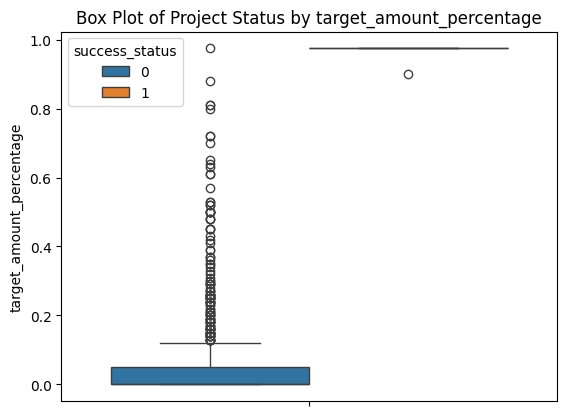

In [35]:
sns.boxplot(y='target_amount_percentage', hue='success_status', data=df_full_train)
plt.title('Box Plot of Project Status by target_amount_percentage')
plt.show()

This feature is very troublesome due to the distribution of *target_amount_percentage* in successful projects. It could significantly affect the predictive power of the model.

In [36]:
Q1 = df_full_train['collected_amount'].quantile(0.25)
Q3 = df_full_train['collected_amount'].quantile(0.75)
IQR = Q3 - Q1

outliers = df_full_train[(df_full_train['collected_amount'] < (Q1 - 1.5 * IQR)) | (df_full_train['collected_amount'] > (Q3 + 1.5 * IQR))]
print(f'Number of Outliers: {len(outliers)}')
print(outliers.head(1).T)
print(f'\nSuccess Rate of outliers in collected_amount: {np.round(outliers['success_status'].mean() * 100, 3)}%')

outliers.describe()

Number of Outliers: 216
                                                     17
platform_name                                   fongogo
mass_funding_type                                 prize
project_category                            culture-art
funding_method                           all-or-nothing
project_name              kültür mantarı sanat hareketi
project_owner                               serina tara
project_owner_gender                              kadın
project_supported                                     2
subscribed_projects                                   0
number_of_projects_owned                              1
number_of_teams                                       0
owner_location                                 istanbul
project_region                                  marmara
launch_year                                        2019
project_start_date                           26.04.2019
project_end_date                             26.05.2019
project_duration        

,project_supported,subscribed_projects,number_of_projects_owned,number_of_teams,launch_year,project_duration,promo_video,promo_video_length,image_count,faq,...,project_member_count,website,social_media,social_media_count,social_media_followers,total_tags,target_amount,collected_amount,target_amount_percentage,success_status
count,216.000000,216.0,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,...,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,2.160000e+02,216.000000,216.000000
mean,1.625000,0.0,1.356481,0.115741,2018.087963,50.625000,0.898148,106.083333,8.004630,0.412037,...,2.504630,0.425926,0.671296,1.509259,6156.097222,1.708333,44478.083333,6.837929e+04,0.889815,0.842593
std,4.670852,0.0,1.136193,0.420998,1.753838,15.720025,0.303156,81.427797,8.235204,1.744531,...,2.110875,0.495631,0.470833,1.304699,28145.440641,2.272817,47792.521853,2.231721e+05,0.217936,0.365030
min,0.000000,0.0,1.000000,0.000000,2011.000000,6.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7500.000000,1.025500e+04,0.090000,0.000000
25%,0.000000,0.0,1.000000,0.000000,2017.000000,40.000000,1.000000,60.000000,2.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15375.000000,1.524750e+04,0.975000,1.000000
50%,0.000000,0.0,1.000000,0.000000,2018.000000,60.000000,1.000000,88.000000,6.000000,0.000000,...,2.000000,0.000000,1.000000,2.000000,414.000000,0.000000,25000.000000,2.291250e+04,0.975000,1.000000
75%,1.000000,0.0,1.000000,0.000000,2020.000000,60.000000,1.000000,145.500000,11.000000,0.000000,...,3.000000,1.000000,1.000000,3.000000,2103.500000,4.000000,50000.000000,4.827925e+04,0.975000,1.000000
max,31.000000,0.0,7.000000,4.000000,2021.000000,109.000000,1.000000,513.000000,57.000000,18.000000,...,16.000000,1.000000,1.000000,4.000000,259000.000000,12.000000,271000.000000,2.666800e+06,0.975000,1.000000


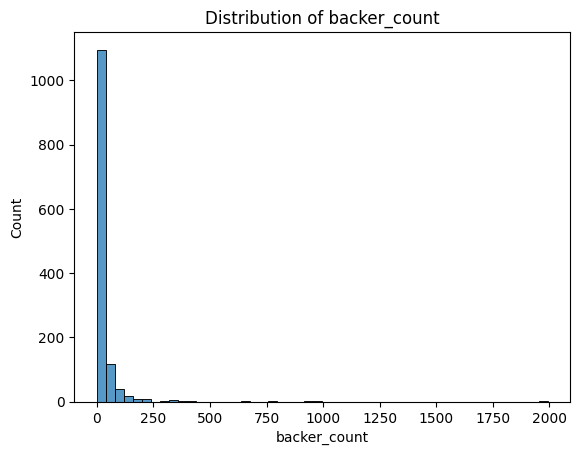

In [37]:
sns.histplot(x='backer_count',  data=df_full_train, bins=50)
plt.title('Distribution of backer_count')
plt.show()

In [38]:
Q1 = df_full_train['backer_count'].quantile(0.25)
Q3 = df_full_train['backer_count'].quantile(0.75)
IQR = Q3 - Q1

outliers = df_full_train[(df_full_train['backer_count'] < (Q1 - 1.5 * IQR)) | (df_full_train['backer_count'] > (Q3 + 1.5 * IQR))]
print(f'Number of Outliers: {len(outliers)}')
print(outliers.head(1).T)
print(f'\nSuccess Rate of outliers in backer_count: {np.round(outliers['success_status'].mean() * 100, 3)}%')

Number of Outliers: 190
                                                     17
platform_name                                   fongogo
mass_funding_type                                 prize
project_category                            culture-art
funding_method                           all-or-nothing
project_name              kültür mantarı sanat hareketi
project_owner                               serina tara
project_owner_gender                              kadın
project_supported                                     2
subscribed_projects                                   0
number_of_projects_owned                              1
number_of_teams                                       0
owner_location                                 istanbul
project_region                                  marmara
launch_year                                        2019
project_start_date                           26.04.2019
project_end_date                             26.05.2019
project_duration        

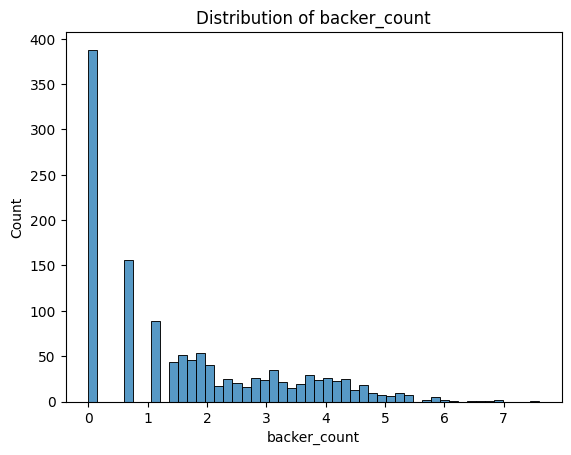

In [39]:
sns.histplot(np.log1p(df_full_train['backer_count']), bins=50)
plt.title('Distribution of backer_count')
plt.show()

<Axes: ylabel='Count'>

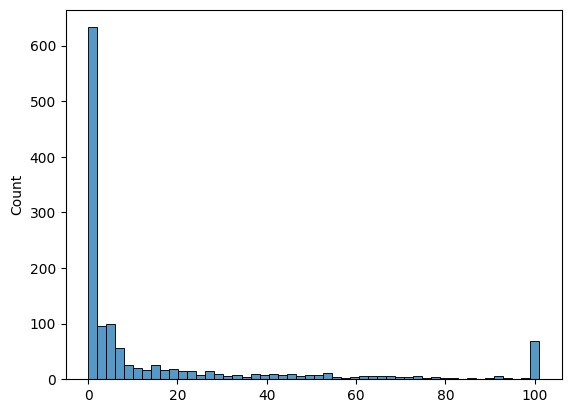

In [40]:
winsorized_data_full = winsorize(df_full_train['backer_count'], limits=[0.05, 0.05])
winsorized_data_test = winsorize(df_test['backer_count'], limits=[0.05, 0.05])

winsorized_data_full
sns.histplot(winsorized_data_full, bins=50)

<Axes: ylabel='Count'>

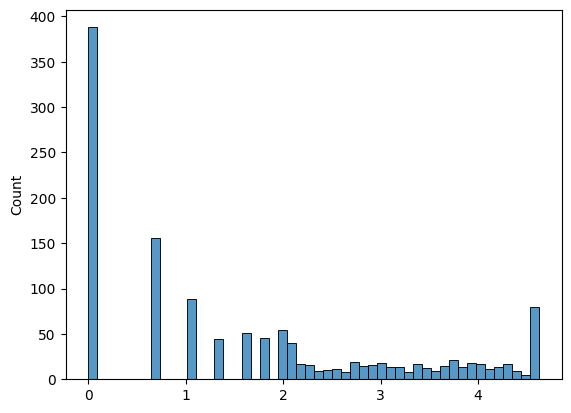

In [41]:
sns.histplot(np.log1p(winsorized_data_full), bins=50)

In [42]:
df_full_train['log_backer_count'] = np.log1p(winsorized_data_full)
df_test['log_backer_count'] = np.log1p(winsorized_data_test)

##### Key Insights:
- Most successful startups have amassed more funds that those that weren't successful.
- The number of backer contributes to the success of the startup, albeit only moderately.
- The number of backer also seems to contribute to the total collected funds.
- The project duration and count of members does not show any correlation to the success of startups.
- The target amount percentage impacts the success of a startup.
- The outliers in the main contributors including *backer_count* and *collected_amount* mostly resulted in success.
- *collected_amount* and *target_amount_percentage* are highly correlated.

### Categorical Variables

In [43]:
categorical_vars = ['mass_funding_type', 'project_category',
       'funding_method', 'project_owner_gender', 'project_region',
] # selected features only

#### Success Rate

In [44]:
success_rates = {}
for column in df_full_train[categorical_vars]:
    success_rates[column] = []
    for v in df_full_train[column].unique():
        success_rate = df_full_train[df_full_train[column] == v].success_status.mean()
        success_rates[column].append((v, success_rate - global_success_rate))

In [45]:
for k, v in success_rates.items():
    print("Category: ", k)
    print("Success Rates: ", v)
    print()

Category:  mass_funding_type
Success Rates:  [('prize', np.float64(-0.00358975424309782)), ('donation', np.float64(0.7747886241352806))]

Category:  project_category
Success Rates:  [('education', np.float64(0.0920300034456254)), ('technology', np.float64(-0.0766606512270383)), ('film-video-photography', np.float64(0.0940068651776258)), ('other', np.float64(-0.08811460167117108)), ('sports', np.float64(0.010082741782339366)), ('music', np.float64(-0.025211375864719443)), ('culture-art', np.float64(-0.030242822405599945)), ('environment', np.float64(-0.007262657916001503)), ('health-beauty', np.float64(0.11689388729317529)), ('publishing', np.float64(-0.03473518538852899)), ('social_responsibility', np.float64(0.34621719556385194)), ('food-eating-drinking', np.float64(-0.0823542330075766)), ('design', np.float64(-0.19295331134859042)), ('tourism', np.float64(0.17478862413528057)), ('dance-performance', np.float64(-0.22521137586471945)), ('animals', np.float64(-0.22521137586471945)), ('f

#### Risk Ratio

In [46]:
risk_ratio = {}
for column in df_full_train[categorical_vars]:
    risk_ratio[column] = []
    for v in df_full_train[column].unique():
        success_rate = df_full_train[df_full_train[column] == v].success_status.mean()
        risk_ratio[column].append((v, success_rate / global_success_rate))

In [47]:
for k, v in risk_ratio.items():
    print("Category: ", k)
    print("Success Rates: ", v)
    print()

Category:  mass_funding_type
Success Rates:  [('prize', np.float64(0.9840605110229684)), ('donation', np.float64(4.440273037542662))]

Category:  project_category
Success Rates:  [('education', np.float64(1.4086383429445688)), ('technology', np.float64(0.65960577731612)), ('film-video-photography', np.float64(1.41741614879212)), ('other', np.float64(0.6087471099856875)), ('sports', np.float64(1.0447701264806264)), ('music', np.float64(0.8880546075085325)), ('culture-art', np.float64(0.8657136110932234)), ('environment', np.float64(0.9677518158746827)), ('health-beauty', np.float64(1.519040776001437)), ('publishing', np.float64(0.8457662928652689)), ('social_responsibility', np.float64(2.5372988785958066)), ('food-eating-drinking', np.float64(0.6343247196489517)), ('design', np.float64(0.1432346141142794)), ('tourism', np.float64(1.776109215017065)), ('dance-performance', np.float64(0.0)), ('animals', np.float64(0.0)), ('fashion', np.float64(1.2686494392979033))]

Category:  funding_met

#### Mutual Info Score

In [48]:
def mutual_info_churn_score(series):
    return mutual_info_score(df_full_train.success_status, series)

filtered_cols = [col for col in categorical_vars if col != 'project_region']
mi = df_full_train[filtered_cols].apply(mutual_info_churn_score).sort_values(ascending=False)
mi

project_category        0.024569
project_owner_gender    0.011453
mass_funding_type       0.006912
funding_method          0.000372
dtype: float64

In [49]:
df_full_train.select_dtypes('object').columns

Index(['platform_name', 'mass_funding_type', 'project_category',
       'funding_method', 'project_name', 'project_owner',
       'project_owner_gender', 'owner_location', 'project_region',
       'project_start_date', 'project_end_date'],
      dtype='object')

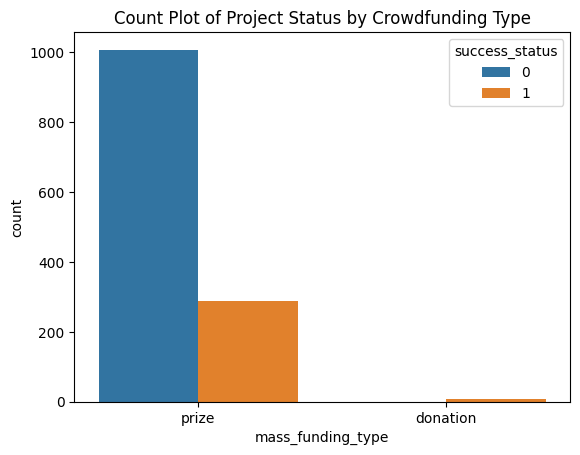

In [50]:
sns.countplot(x='mass_funding_type', hue='success_status', data=df_full_train)
plt.title('Count Plot of Project Status by Crowdfunding Type')
plt.show()

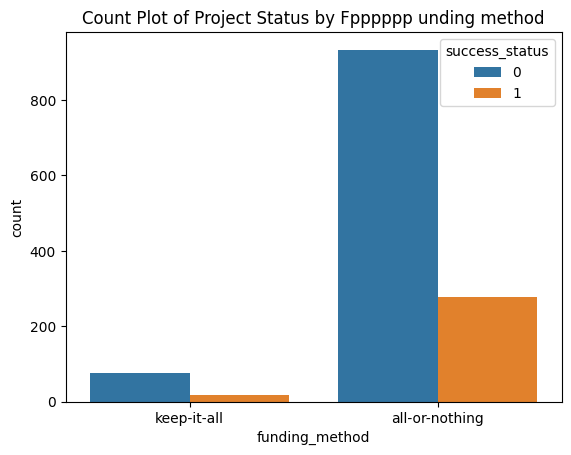

In [51]:
sns.countplot(x='funding_method', hue='success_status', data=df_full_train)
plt.title('Count Plot of Project Status by Fpppppp unding method')
plt.show()

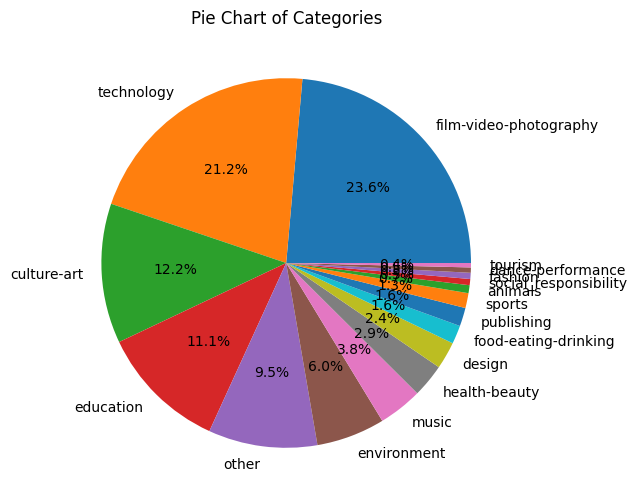

In [52]:
df_full_train['project_category'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(6, 6))
plt.title('Pie Chart of Categories')
plt.ylabel('')  # Optional: Remove ylabel
plt.show()

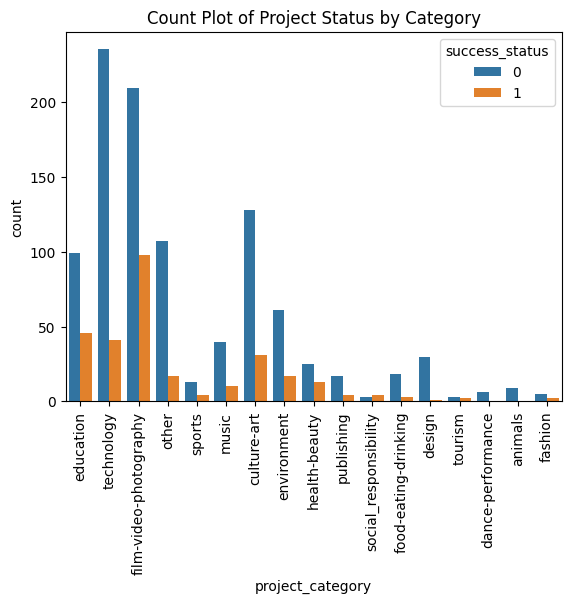

In [53]:
sns.countplot(x='project_category', hue='success_status', data=df_full_train)
plt.title('Count Plot of Project Status by Category')
plt.xticks(rotation=90)
plt.show()

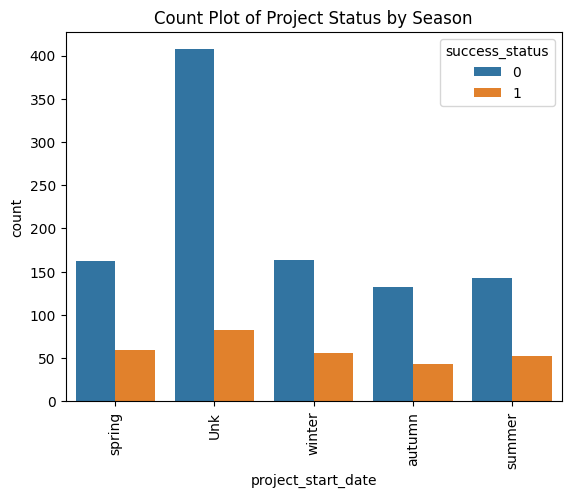

In [54]:
def replace_month(x):
    # month = int(x.replace('.', ' ')[3:5])
    if pd.isnull(x):
        return 'Unk'
    month = pd.to_datetime(x, errors='coerce', dayfirst=True).month  # Convert to datetime and extract month
    if month >= 3 and month <= 5:
        return "spring"
    elif month >= 6 and month <= 8:
        return "summer"
    elif month >= 9 and month <= 11:
        return "autumn"
    else:
        return "winter"

project_seasons = df_full_train['project_start_date'].apply(replace_month)

sns.countplot(x=project_seasons, hue='success_status', data=df_full_train)
plt.title('Count Plot of Project Status by Season')
plt.xticks(rotation=90)
plt.show()

##### Key Insights:
- Technology and film-video-photography is the most common startup.
- All-or-nothing seems to be much preferred than keep-it-all.
- Donation is very rare. Most funders seek prizes/rewards.

## Model Selection

### Data Preprocessing

In [55]:
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=len(df_test), random_state=42)

del df_train['success_status']
del df_val['success_status']
del df_test['success_status']

df_train.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

##### Dropping columns after EDA

In [56]:
# these are columns that did not affect the target variable or has been opted out due to the creator's decision
to_drop = ['project_end_date', 'project_start_date', 'launch_year', 'project_owner', 
    'owner_location', 'project_name', 'collected_amount', 'project_owner_gender', 
    'subscribed_projects', 'target_amount_percentage', 'backer_count',
    'platform_name', 'project_region'
]

# just to experiment, I am dropping the target_amount_percentage that contributes so much to the result
df_train.drop(columns=to_drop, errors='ignore', inplace=True)
df_val.drop(columns=to_drop, errors='ignore', inplace=True)

dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv.fit(train_dicts)
X_train = dv.transform(train_dicts)
X_val = dv.transform(val_dicts)

### Feature Importance with Random Forest Classifier

In [58]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

feature_importance = dict(zip(dv.feature_names_, rf.feature_importances_))

sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# most important features
for feature, importance in sorted_importance:
    print(f"{feature}: {importance:.4f}")

log_backer_count: 0.4164
promo_video_length: 0.0677
target_amount: 0.0588
updates: 0.0532
reward_count: 0.0411
project_supported: 0.0411
social_media_followers: 0.0390
image_count: 0.0372
promo_video: 0.0327
project_member_count: 0.0259
project_duration: 0.0228
comments: 0.0191
total_tags: 0.0168
social_media_count: 0.0155
funding_method=keep-it-all: 0.0130
project_category=film-video-photography: 0.0097
funding_method=all-or-nothing: 0.0088
faq: 0.0072
social_media: 0.0067
website: 0.0067
project_category=technology: 0.0063
number_of_teams: 0.0063
number_of_projects_owned: 0.0057
project_category=education: 0.0057
project_category=other: 0.0056
project_category=music: 0.0045
project_category=social_responsibility: 0.0044
project_category=culture-art: 0.0042
mass_funding_type=donation: 0.0035
project_category=environment: 0.0032
project_category=health-beauty: 0.0026
mass_funding_type=prize: 0.0025
project_category=food-eating-drinking: 0.0014
project_category=publishing: 0.0012
projec

In [59]:
# check for VIF for multicollinearity
X = df[['collected_amount', 'target_amount', 'target_amount_percentage', 'backer_count']]
vif = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif)

                    Feature       VIF
0          collected_amount  3.982014
1             target_amount  1.073181
2  target_amount_percentage  3.746376
3              backer_count  1.135874


I'll drop *collected_amount* to avoid redundancy.

In [60]:
y_preds_proba = rf.predict_proba(X_val)[:,1]
y_preds = rf.predict(X_val)

print(f'ROC_AUC Score: {np.round(roc_auc_score(y_val, y_preds_proba), 3)}')
print(f'Accuracy Score: {np.round(accuracy_score(y_val, y_preds), 3)}')

ROC_AUC Score: 0.98
Accuracy Score: 0.945


##### Key Insights:
- I may need to output only the probabilty of success instead of deterministic 1/0.
- The features are very good at capturing the pattern proven by the *ROC AUC score* and *Accuracy score*
- There is a need to find a suitable threshold in case of needing to ouput discrete values such as 1/0.

### Model Training

#### Logistic Regression

In [61]:
model_scores = {}

In [62]:
model = LogisticRegression(random_state=42, max_iter=3500, solver='liblinear')
model.fit(X_train, y_train)

y_preds_proba = model.predict_proba(X_val)
y_preds = model.predict(X_val)

accuracy = np.round(accuracy_score(y_val, y_preds), 3)
recall = np.round(recall_score(y_val, y_preds), 3)
f1score = np.round(f1_score(y_val, y_preds), 3)
precision = np.round(precision_score(y_val, y_preds), 3)
auc_score = np.round(roc_auc_score(y_val, y_preds_proba[:,1]), 3)
log_ls = np.round(log_loss(y_val, y_preds_proba), 3)

model_scores['logit_regression'] = (accuracy, recall, f1score, precision, auc_score, log_ls)
print(f'Accuracy Score: {accuracy}')
print(f'Recall Score: {recall}')
print(f'f1 Score: {f1score}')
print(f'Precision Score: {precision}')
print(f'ROC_AUC Score: {auc_score}')
print(f'Log Loss: {log_ls}')

Accuracy Score: 0.929
Recall Score: 0.817
f1 Score: 0.854
Precision Score: 0.893
ROC_AUC Score: 0.961
Log Loss: 0.219


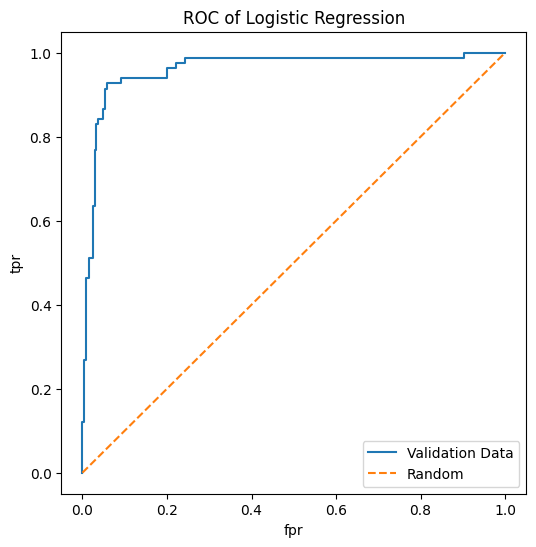

In [63]:
lfpr, ltpr, lt = roc_curve(y_val, y_preds_proba[:,1])
plt.figure(figsize=(6,6))
plt.title('ROC of Logistic Regression')
plt.plot(lfpr, ltpr, label='Validation Data')
plt.plot([0, 1], [0, 1], label='Random', linestyle='dashed')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.show()

#### Random Forest Classifier

In [64]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_preds_proba = model.predict_proba(X_val)
y_preds = model.predict(X_val)

accuracy = np.round(accuracy_score(y_val, y_preds), 3)
recall = np.round(recall_score(y_val, y_preds), 3)
f1score = np.round(f1_score(y_val, y_preds), 3)
precision = np.round(precision_score(y_val, y_preds), 3)
auc_score = np.round(roc_auc_score(y_val, y_preds_proba[:,1]), 3)
log_ls = np.round(log_loss(y_val, y_preds_proba), 3)

model_scores['random_forest_classif'] = (accuracy, recall, f1score, precision, auc_score, log_ls)
print(f'Accuracy Score: {accuracy}')
print(f'Recall Score: {recall}')
print(f'f1 Score: {f1score}')
print(f'Precision Score: {precision}')
print(f'ROC_AUC Score: {auc_score}')
print(f'Log Loss: {log_ls}')

Accuracy Score: 0.945
Recall Score: 0.841
f1 Score: 0.885
Precision Score: 0.932
ROC_AUC Score: 0.98
Log Loss: 0.179


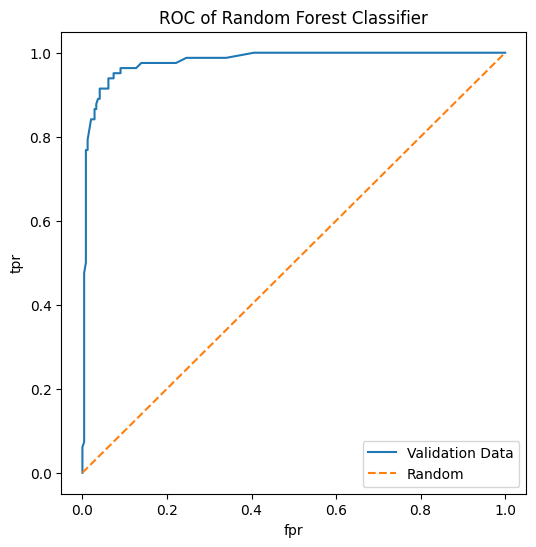

In [65]:
rfpr, rtpr, rt = roc_curve(y_val, y_preds_proba[:,1])
plt.figure(figsize=(6,6))
plt.title('ROC of Random Forest Classifier')
plt.plot(rfpr, rtpr, label='Validation Data')
plt.plot([0, 1], [0, 1], label='Random', linestyle='dashed')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.show()

#### XGB Classifier

In [66]:
# create model instance
model = XGBClassifier(objective='binary:logistic', random_state=42)
# fit model
model.fit(X_train, y_train)

# predict
y_preds_proba = model.predict_proba(X_val)
y_preds = model.predict(X_val)

accuracy = np.round(accuracy_score(y_val, y_preds), 3)
recall = np.round(recall_score(y_val, y_preds), 3)
f1score = np.round(f1_score(y_val, y_preds), 3)
precision = np.round(precision_score(y_val, y_preds), 3)
auc_score = np.round(roc_auc_score(y_val, y_preds_proba[:,1]), 3)
log_ls = np.round(log_loss(y_val, y_preds_proba), 3)

model_scores['xgb_classifier'] = (accuracy, recall, f1score, precision, auc_score, log_ls)
print(f'Accuracy Score: {accuracy}')
print(f'Recall Score: {recall}')
print(f'f1 Score: {f1score}')
print(f'Precision Score: {precision}')
print(f'ROC_AUC Score: {auc_score}')
print(f'Log Loss: {log_ls}')

Accuracy Score: 0.936
Recall Score: 0.817
f1 Score: 0.865
Precision Score: 0.918
ROC_AUC Score: 0.978
Log Loss: 0.221


<Axes: ylabel='Count'>

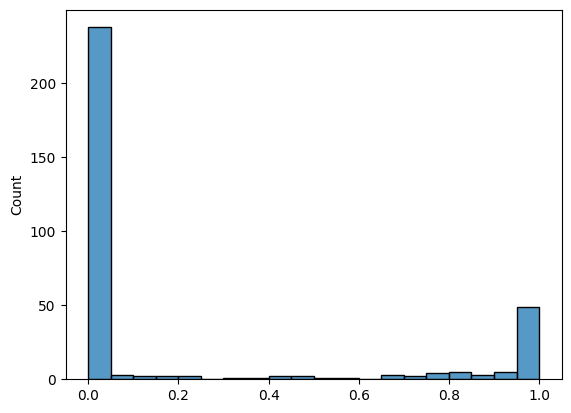

In [67]:
sns.histplot(x=y_preds_proba[:,1])

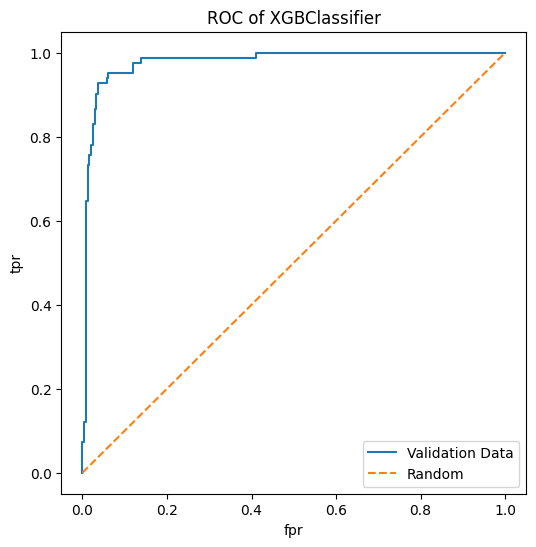

In [68]:
xfpr, xtpr, xt = roc_curve(y_val, y_preds_proba[:,1])
plt.figure(figsize=(6,6))
plt.title('ROC of XGBClassifier')
plt.plot(xfpr, xtpr, label='Validation Data')
plt.plot([0, 1], [0, 1], label='Random', linestyle='dashed')
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
plt.show()

### Fine-Tuning

For tuning, I mainly care about the **Log Loss** so that will be my main metric for comparison. Log Loss is a function that we can use to identify how close the prediction probability is to the corresponding **true value**.

#### Logistic Regression

##### Regularization

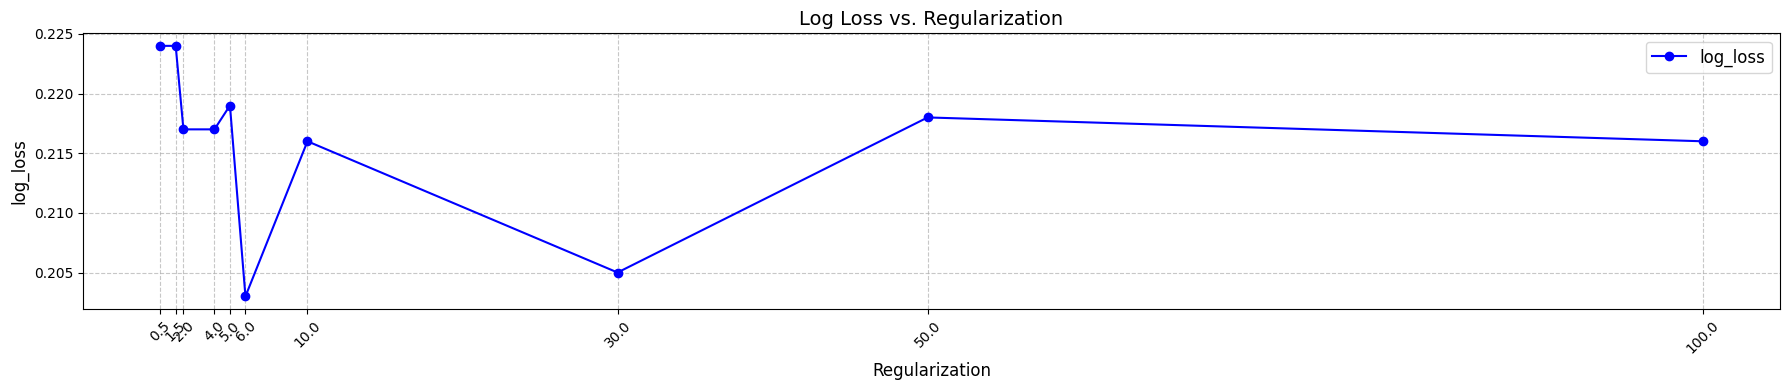

In [69]:
Cs = [0.1, 0.5, 1.0, 1.5, 2.0, 4.0, 5.0, 6.0, 10.0, 30.0, 50.0, 100.0]
regularization_scores = {}
for reg in Cs:
    current_score = []
    model = LogisticRegression(random_state=42, max_iter=3500, solver='liblinear', C=reg)
    model.fit(X_train, y_train)
    
    # predict
    y_preds_proba = model.predict_proba(X_val)
    y_preds = model.predict(X_val)
    
    log_ls = np.round(log_loss(y_val, y_preds_proba), 3)
    current_score.append((reg, log_ls))
    regularization_scores[f"regularization={int(reg)}"] = pd.DataFrame(current_score, columns=['reg', 'log_loss'])

regs = []
log_ls = []

for key, dfs in regularization_scores.items():
    regs.append(dfs['reg'].iloc[0])
    log_ls.append(dfs['log_loss'].iloc[0])

plt.figure(figsize=(18, 4))
plt.plot(regs, log_ls, marker='o', linestyle='-', color='b', label="log_loss")
plt.title("Log Loss vs. Regularization", fontsize=14)
plt.xlabel("Regularization", fontsize=12)
plt.ylabel("log_loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(regs, rotation=45)
plt.tight_layout()
plt.show()

In [70]:
model = LogisticRegression(random_state=42, max_iter=3500, solver='liblinear', C=6.0)
model.fit(X_train, y_train)

y_preds_proba = model.predict_proba(X_val)
y_preds = model.predict(X_val)

accuracy = np.round(accuracy_score(y_val, y_preds), 3)
recall = np.round(recall_score(y_val, y_preds), 3)
f1score = np.round(f1_score(y_val, y_preds), 3)
precision = np.round(precision_score(y_val, y_preds), 3)
auc_score = np.round(roc_auc_score(y_val, y_preds_proba[:,1]), 3)
log_ls = np.round(log_loss(y_val, y_preds_proba), 3)

model_scores['logit_regression_tuned'] = (accuracy, recall, f1score, precision, auc_score, log_ls)
print(f'Accuracy Score: {accuracy}')
print(f'Recall Score: {recall}')
print(f'f1 Score: {f1score}')
print(f'Precision Score: {precision}')
print(f'ROC_AUC Score: {auc_score}')
print(f'Log Loss: {log_ls}')

Accuracy Score: 0.92
Recall Score: 0.78
f1 Score: 0.831
Precision Score: 0.889
ROC_AUC Score: 0.965
Log Loss: 0.203


#### Random Forest Classifier

##### n_estimators

Processing: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


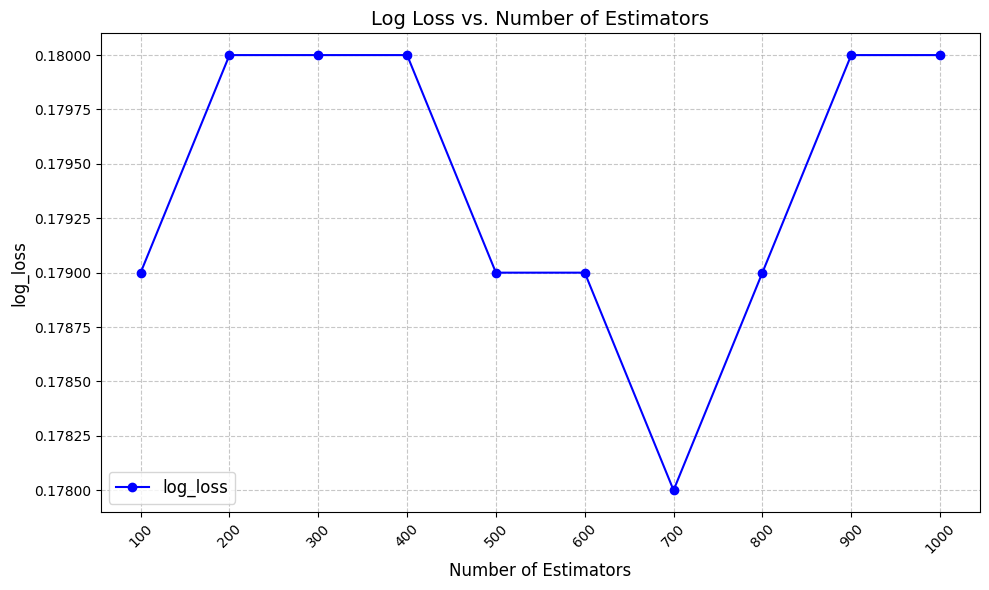

In [71]:
estimators = np.linspace(100, 1000, 10)
rf_scores = {}
for n_estimators in tqdm(estimators, desc="Processing"):
    current_score = []
    model = RandomForestClassifier(n_estimators=int(n_estimators), 
                                   random_state=42, 
                                   n_jobs=-1)
    model.fit(X_train, y_train)
    # predict
    y_preds_proba = model.predict_proba(X_val)
    y_preds = model.predict(X_val)
    
    log_ls = np.round(log_loss(y_val, y_preds_proba), 3)
    current_score.append((n_estimators, log_ls))
    rf_scores[f"n_estimators={int(n_estimators)}"] = pd.DataFrame(current_score, columns=['est', 'log_loss'])
    
n_estimators_list = []
log_ls = []

for key, dfs in rf_scores.items():
    n_estimators_list.append(dfs['est'].iloc[0])
    log_ls.append(dfs['log_loss'].iloc[0])

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, log_ls, marker='o', linestyle='-', color='b', label="log_loss")
plt.title("Log Loss vs. Number of Estimators", fontsize=14)
plt.xlabel("Number of Estimators", fontsize=12)
plt.ylabel("log_loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(n_estimators_list, rotation=45)
plt.tight_layout()
plt.show()

In [72]:
n_estimator=100

##### max_depth

In [73]:
depths = np.linspace(2, 32, 16)
depth_scores = {}
for depth in tqdm(depths, desc="Processing"):
    current_score = []
    model = RandomForestClassifier(n_estimators=100,
                                   max_depth=int(depth),
                                   random_state=42, 
                                   n_jobs=-1)
    model.fit(X_train, y_train)
    # predict
    y_preds_proba = model.predict_proba(X_val)
    y_preds = model.predict(X_val)
    
    log_ls = np.round(log_loss(y_val, y_preds_proba), 3)
    current_score.append((depth, log_ls))
    depth_scores[f"max_depth={int(depth)}"] = pd.DataFrame(current_score, columns=['depth', 'log_loss'])

Processing: 100%|██████████| 16/16 [00:01<00:00,  8.14it/s]


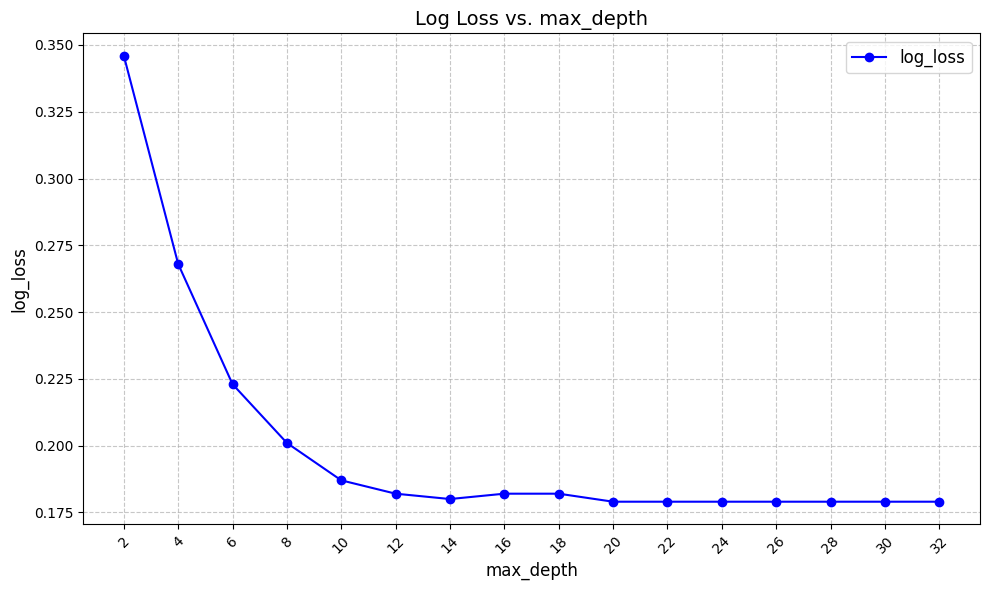

In [74]:
max_depth_list = []
log_ls = []

for key, dfs in depth_scores.items():
    max_depth_list.append(dfs['depth'].iloc[0])
    log_ls.append(dfs['log_loss'].iloc[0])

plt.figure(figsize=(10, 6))
plt.plot(max_depth_list, log_ls, marker='o', linestyle='-', color='b', label="log_loss")
plt.title("Log Loss vs. max_depth", fontsize=14)
plt.xlabel("max_depth", fontsize=12)
plt.ylabel("log_loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(max_depth_list, rotation=45)
plt.tight_layout()
plt.show()

In [75]:
possible_depths = [10, 12, 14, 16]

##### min_samples_split

In [76]:
splits = np.linspace(5, 100, 20)
depth_scores = {}
for depth in tqdm(possible_depths, desc="Processing"):
    current_score = []
    for samples in splits:
        model = RandomForestClassifier(n_estimators=100,
                                       max_depth=int(depth),
                                       min_samples_split=int(samples),
                                       random_state=42, 
                                       n_jobs=-1)
        model.fit(X_train, y_train)
        # predict
        y_preds_proba = model.predict_proba(X_val)
        y_preds = model.predict(X_val)
        
        log_ls = np.round(log_loss(y_val, y_preds_proba), 3)
        current_score.append((depth, samples, log_ls))
    depth_scores[f"max_depth={int(depth)}"] = pd.DataFrame(current_score, columns=['depth', 'samples_per_split', 'log_loss'])

Processing: 100%|██████████| 4/4 [00:09<00:00,  2.45s/it]


Text(0, 0.5, 'log_loss')

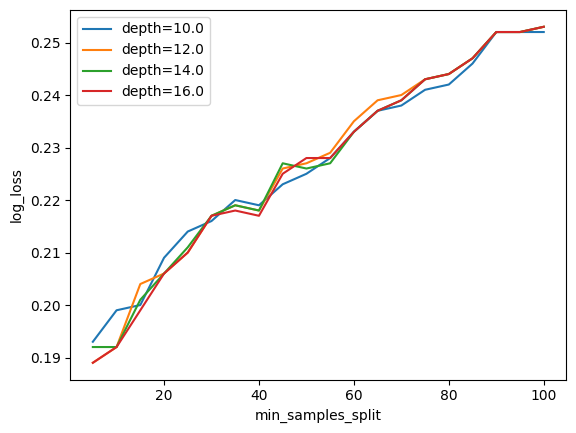

In [78]:
for key, dfs in depth_scores.items():
    plt.plot(dfs.samples_per_split, dfs.log_loss, label=f'depth={dfs.iloc[0].depth}')
plt.legend()
plt.xlabel("min_samples_split")
plt.ylabel('log_loss')

In [79]:
splits=[2,3,4,5,6,10,15,20,25,30,50]
samples_scores = {}
for samples in splits:
    current_score = []
    model = RandomForestClassifier(n_estimators=100,
                                       max_depth=16,
                                       min_samples_split=samples,
                                       random_state=42, 
                                       n_jobs=-1)
    model.fit(X_train, y_train)
    # predict
    y_preds_proba = model.predict_proba(X_val)
    y_preds = model.predict(X_val)
    
    log_ls = np.round(log_loss(y_val, y_preds_proba), 3)
    current_score.append((samples, log_ls))
    samples_scores[f"min_samples_split={int(samples)}"] = pd.DataFrame(current_score, columns=['min_samples_split', 'log_loss'])

Text(0, 0.5, 'log_loss')

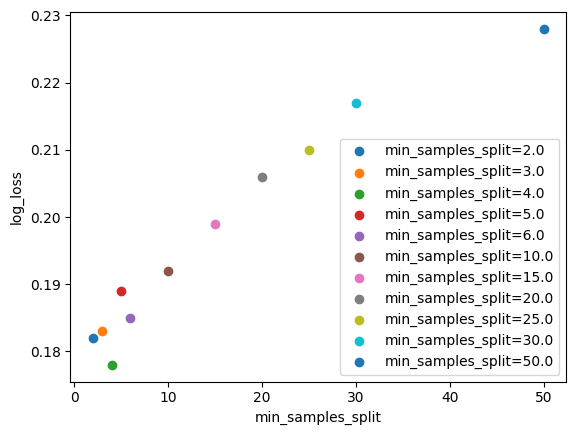

In [80]:
for key, dfs in samples_scores.items():
    plt.scatter(dfs.min_samples_split, dfs.log_loss, label=f'min_samples_split={dfs.iloc[0].min_samples_split}')
plt.legend()
plt.xlabel("min_samples_split")
plt.ylabel('log_loss')

In [81]:
min_samples_split=4

In [82]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=16,
    min_samples_split=4,
    random_state=42, 
    n_jobs=-1
)
model.fit(X_train, y_train)

# predict
y_preds_proba = model.predict_proba(X_val)
y_preds = model.predict(X_val)

accuracy = np.round(accuracy_score(y_val, y_preds), 3)
recall = np.round(recall_score(y_val, y_preds), 3)
f1score = np.round(f1_score(y_val, y_preds), 3)
precision = np.round(precision_score(y_val, y_preds), 3)
auc_score = np.round(roc_auc_score(y_val, y_preds_proba[:,1]), 3)
log_ls = np.round(log_loss(y_val, y_preds_proba), 3)

model_scores['random_forest_classif_tuned'] = (accuracy, recall, f1score, precision, auc_score, log_ls)
print(f'Accuracy Score: {accuracy}')
print(f'Recall Score: {recall}')
print(f'f1 Score: {f1score}')
print(f'Precision Score: {precision}')
print(f'ROC_AUC Score: {auc_score}')
print(f'Log Loss: {log_ls}')

Accuracy Score: 0.957
Recall Score: 0.866
f1 Score: 0.91
Precision Score: 0.959
ROC_AUC Score: 0.982
Log Loss: 0.178


#### XGB Classifier

##### n_estimators

In [83]:
# create model instance
early_stop = xgb.callback.EarlyStopping(
    rounds=5, metric_name='logloss', data_name='validation_0', save_best=True
)

model = XGBClassifier (
    objective='binary:logistic', 
    random_state=42,
    n_estimators=500,
    tree_method='hist',
    callbacks=[early_stop]
)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)]);

[0]	validation_0-logloss:0.39747


[1]	validation_0-logloss:0.32013
[2]	validation_0-logloss:0.27321
[3]	validation_0-logloss:0.24331
[4]	validation_0-logloss:0.22108
[5]	validation_0-logloss:0.21074
[6]	validation_0-logloss:0.20335
[7]	validation_0-logloss:0.19683
[8]	validation_0-logloss:0.19245
[9]	validation_0-logloss:0.18389
[10]	validation_0-logloss:0.18404
[11]	validation_0-logloss:0.18222
[12]	validation_0-logloss:0.18261
[13]	validation_0-logloss:0.18499
[14]	validation_0-logloss:0.18352
[15]	validation_0-logloss:0.18650
[16]	validation_0-logloss:0.18623


#####  Learning Rate

In [84]:
%%capture
etas = np.linspace(0.1,1.0,20)
xgb_scores = {}
for eta in tqdm(etas, desc='Processing...'):
    current_score = []
    # create model instance
    early_stop = xgb.callback.EarlyStopping(
        rounds=5, metric_name='logloss', data_name='validation_0', save_best=True
    )

    # create model instance
    model = XGBClassifier (
        objective='binary:logistic', 
        random_state=42,
        n_estimators=500,
        learning_rate=eta,
        tree_method='hist',
        callbacks=[early_stop]
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    y_preds_proba = model.predict_proba(X_val)[:,1]
    y_preds = model.predict(X_val)

    log_ls = log_loss(y_val,  model.predict_proba(X_val))
    current_score.append((eta, log_ls))
    xgb_scores[f"eta={eta}"] = pd.DataFrame(current_score, columns=['eta', 'log_loss'])

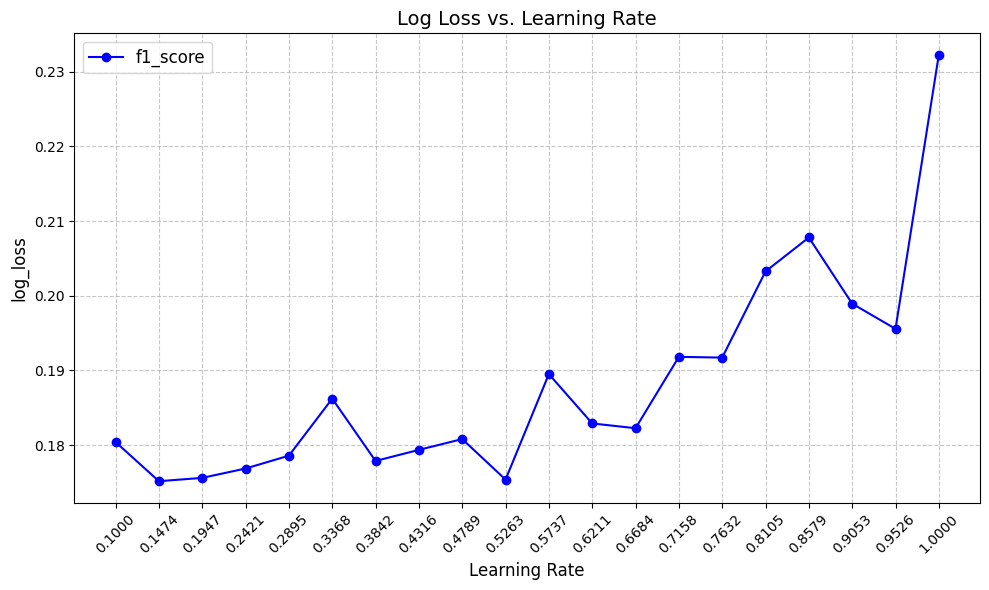

In [85]:
eta_list = []
logs = []

for key, dfs in xgb_scores.items():
    eta_list.append(dfs['eta'].iloc[0])
    logs.append(dfs['log_loss'].iloc[0])

plt.figure(figsize=(10, 6))
plt.plot(eta_list, logs, marker='o', linestyle='-', color='b', label="f1_score")
plt.title("Log Loss vs. Learning Rate", fontsize=14)
plt.xlabel("Learning Rate", fontsize=12)
plt.ylabel("log_loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(eta_list, rotation=45)
plt.tight_layout()
plt.show()

In [86]:
learning_rate = 0.5263

In [87]:
%%capture
depths = np.linspace(2, 20, 10)
xgb_scores = {}
for d in depths:
    current_score=[]
    # create model instance
    early_stop = xgb.callback.EarlyStopping(
        rounds=5, metric_name='logloss', data_name='validation_0', save_best=True
    )
    model = XGBClassifier (
        objective='binary:logistic', 
        random_state=42,
        n_estimators=300,
        learning_rate=0.5263,
        tree_method='hist',
        callbacks=[early_stop],
        max_depth=int(d)
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)]);
    
    y_preds_proba = model.predict_proba(X_val)
    y_preds = model.predict(X_val)

    log_ls = log_loss(y_val,  y_preds_proba)
    current_score.append((int(d), log_ls))
    xgb_scores[f"depth={int(d)}"] = pd.DataFrame(current_score, columns=['max_depth', 'log_loss'])

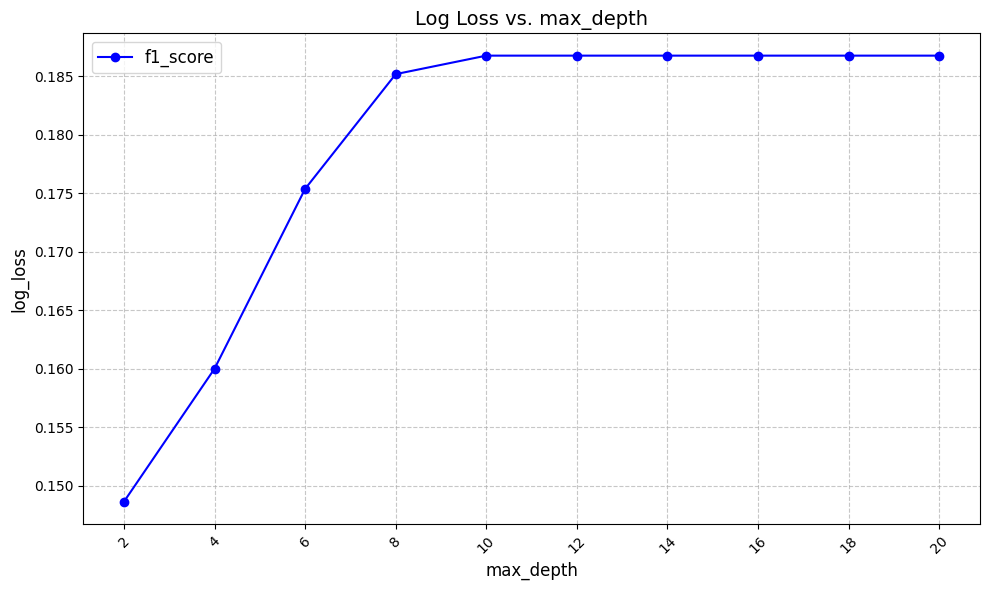

In [88]:
depth_list = []
logs = []

for key, dfs in xgb_scores.items():
    depth_list.append(dfs['max_depth'].iloc[0])
    logs.append(dfs['log_loss'].iloc[0])

plt.figure(figsize=(10, 6))
plt.plot(depth_list, logs, marker='o', linestyle='-', color='b', label="f1_score")
plt.title("Log Loss vs. max_depth", fontsize=14)
plt.xlabel("max_depth", fontsize=12)
plt.ylabel("log_loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(depth_list, rotation=45)
plt.tight_layout()
plt.show()

In [91]:
early_stop = xgb.callback.EarlyStopping(
    rounds=5, metric_name='logloss', data_name='validation_0', save_best=True
)

model = XGBClassifier (
    objective='binary:logistic', 
    random_state=42,
    n_estimators=300,
    learning_rate=0.5263,
    tree_method='hist',
    callbacks=[early_stop],
    max_depth=2
)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)]);

[0]	validation_0-logloss:0.31917
[1]	validation_0-logloss:0.25461
[2]	validation_0-logloss:0.22558
[3]	validation_0-logloss:0.20406
[4]	validation_0-logloss:0.18926
[5]	validation_0-logloss:0.18375
[6]	validation_0-logloss:0.17092
[7]	validation_0-logloss:0.16922
[8]	validation_0-logloss:0.16556
[9]	validation_0-logloss:0.16120
[10]	validation_0-logloss:0.15720
[11]	validation_0-logloss:0.15756
[12]	validation_0-logloss:0.15722
[13]	validation_0-logloss:0.15506
[14]	validation_0-logloss:0.15374
[15]	validation_0-logloss:0.15200


[16]	validation_0-logloss:0.14864
[17]	validation_0-logloss:0.15158
[18]	validation_0-logloss:0.15060
[19]	validation_0-logloss:0.15138
[20]	validation_0-logloss:0.15519


In [92]:
y_preds_proba = model.predict_proba(X_val)
y_preds = model.predict(X_val)

accuracy = np.round(accuracy_score(y_val, y_preds), 3)
recall = np.round(recall_score(y_val, y_preds), 3)
f1score = np.round(f1_score(y_val, y_preds), 3)
precision = np.round(precision_score(y_val, y_preds), 3)
auc_score = np.round(roc_auc_score(y_val, y_preds_proba[:,1]), 3)
log_ls = np.round(log_loss(y_val, y_preds_proba), 3)

model_scores['xgb_classifier_tuned'] = (accuracy, recall, f1score, precision, auc_score, log_ls)
print(f'Accuracy Score: {accuracy}')
print(f'Recall Score: {recall}')
print(f'f1 Score: {f1score}')
print(f'Precision Score: {precision}')
print(f'Log Loss: {log_ls}')

Accuracy Score: 0.954
Recall Score: 0.89
f1 Score: 0.907
Precision Score: 0.924
Log Loss: 0.149


### Model Scores

In [93]:
df_models = pd.DataFrame(model_scores)
df_models['metric'] = ['accuracy', 'recall', 'f1score', 'precision', 'roc_auc_score', 'log_loss']
df_models.set_index('metric', inplace=True)

def highlight_max_min(s):
    '''
    Highlight the maximum value in green and the minimum value in blue for a row.
    '''
    max_color = 'background-color: lightgreen'
    min_color = 'background-color: lightblue'
    default_color = ''  # No color

    # Create a list with default styles
    styles = [default_color] * len(s)

    # Use s.values.argmax() and s.values.argmin() for positions
    styles[s.values.argmax()] = max_color
    styles[s.values.argmin()] = min_color

    return styles

styled_df = df_models.style.apply(highlight_max_min, axis=1)
styled_df

,logit_regression,random_forest_classif,xgb_classifier,logit_regression_tuned,random_forest_classif_tuned,xgb_classifier_tuned
metric,,,,,,
accuracy,0.929000,0.945000,0.936000,0.920000,0.957000,0.954000
recall,0.817000,0.841000,0.817000,0.780000,0.866000,0.890000
f1score,0.854000,0.885000,0.865000,0.831000,0.910000,0.907000
precision,0.893000,0.932000,0.918000,0.889000,0.959000,0.924000
roc_auc_score,0.961000,0.980000,0.978000,0.965000,0.982000,0.982000
log_loss,0.219000,0.179000,0.221000,0.203000,0.178000,0.149000


### Full Training

In [94]:
to_drop.append('success_status')

In [95]:
df_full_train.drop(columns=to_drop, inplace=True, errors='ignore')
df_test.drop(columns=to_drop, inplace=True, errors='ignore')

In [108]:
dv = DictVectorizer(sparse=False)

# convert to dictionary before transforming or DictVectorizer
full_train_dicts = df_full_train.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

X_full = dv.fit_transform(full_train_dicts)
X_test = dv.transform(test_dicts)


# handle imbalance by using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_full, y_full_train)

# # create model instance
# model = XGBClassifier(objective='binary:logistic', random_state=42)
# fit model

early_stop = xgb.callback.EarlyStopping(
    rounds=8, metric_name='logloss', data_name='validation_0', save_best=True
)

model = XGBClassifier (
    objective='binary:logistic', 
    random_state=42,
    n_estimators=300,
    learning_rate=0.5263,
    tree_method='hist',
    callbacks=[early_stop],
    max_depth=2
)

model.fit(X_res, y_res, eval_set=[(X_test, y_test)]) # use the balanced dataset

y_preds_proba = model.predict_proba(X_test)
y_preds = model.predict(X_test)

accuracy = np.round(accuracy_score(y_test, y_preds), 3)
recall = np.round(recall_score(y_test, y_preds), 3)
f1score = np.round(f1_score(y_test, y_preds), 3)
precision = np.round(precision_score(y_test, y_preds), 3)
auc_score = np.round(roc_auc_score(y_test, y_preds_proba[:,1]), 3)
log_ls = np.round(log_loss(y_test, y_preds_proba), 3)

print(f'Accuracy Score: {accuracy}')
print(f'Recall Score: {recall}')
print(f'f1 Score: {f1score}')
print(f'Precision Score: {precision}')
print(f'ROC_AUC Score: {auc_score}')
print(f'Log Loss: {log_ls}')

[0]	validation_0-logloss:0.41588
[1]	validation_0-logloss:0.31524
[2]	validation_0-logloss:0.26861
[3]	validation_0-logloss:0.24472
[4]	validation_0-logloss:0.22041
[5]	validation_0-logloss:0.20880
[6]	validation_0-logloss:0.19289
[7]	validation_0-logloss:0.18923
[8]	validation_0-logloss:0.18301
[9]	validation_0-logloss:0.17706
[10]	validation_0-logloss:0.18247
[11]	validation_0-logloss:0.18066
[12]	validation_0-logloss:0.17735
[13]	validation_0-logloss:0.17401
[14]	validation_0-logloss:0.17378
[15]	validation_0-logloss:0.17037
[16]	validation_0-logloss:0.17378
[17]	validation_0-logloss:0.17107
[18]	validation_0-logloss:0.17182
[19]	validation_0-logloss:0.17012
[20]	validation_0-logloss:0.17051
[21]	validation_0-logloss:0.16742
[22]	validation_0-logloss:0.16680
[23]	validation_0-logloss:0.16365
[24]	validation_0-logloss:0.16275
[25]	validation_0-logloss:0.15899
[26]	validation_0-logloss:0.15590
[27]	validation_0-logloss:0.15690
[28]	validation_0-logloss:0.15897
[29]	validation_0-loglos

<Axes: ylabel='Count'>

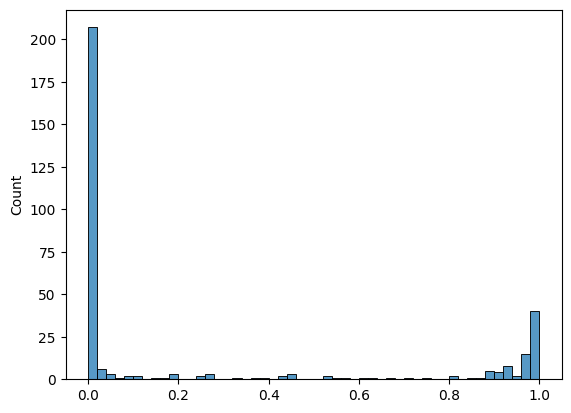

In [109]:
sns.histplot(y_preds_proba[:,1], bins=50)

In [110]:
feature_weights = list(zip(dv.feature_names_, model.feature_importances_))

sorted_feature_weights = sorted(feature_weights, key=lambda x: x[1], reverse=True)
df_features = pd.DataFrame(sorted_feature_weights, columns=['feature', 'weight']).set_index('feature')
df_features[:15]

,weight
feature,
log_backer_count,0.367567
funding_method=all-or-nothing,0.097675
promo_video,0.078523
updates,0.042217
target_amount,0.040441
comments,0.034154
project_category=film-video-photography,0.032792
number_of_projects_owned,0.030787
number_of_teams,0.029741


In [111]:
required_columns = df_full_train.columns

test_data = df[df.success_status == 1].iloc[0].to_dict()
transformed_dictionary = {feature: value for feature, value in test_data.items() if feature in required_columns or feature == 'backer_count'}

transformed_dictionary['log_backer_count'] = np.log1p(transformed_dictionary['backer_count'])
del transformed_dictionary['backer_count']
X = dv.transform(transformed_dictionary)
probability_of_success = model.predict_proba(X)[:,1].round(4)[0] * 100

print(f"Success probability of the project: {probability_of_success:.2f}")

Success probability of the project: 91.53


### Saving with Pickle

In [112]:
output_file=f'startup-success-predictor.bin'

# f_out = open(output_file, 'wb')
with open(output_file, 'wb') as f_out:
    pickle.dump((model, dv), f_out)

### Loading the model

In [113]:
import pickle

model_file=f'startup-success-predictor.bin'

with open(model_file, 'rb') as f_in:
    model, dv = pickle.load(f_in)

model, dv

(XGBClassifier(base_score=None, booster=None,
               callbacks=[<xgboost.callback.EarlyStopping object at 0x7f74701ea960>],
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.5263, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=2, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=300, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...),
 DictVectorizer(sparse=False))

In [114]:
import numpy as np

test_data = {'mass_funding_type': 'prize',
 'project_category': 'other',
 'funding_method': 'all-or-nothing',
 'project_supported': 1,
 'number_of_projects_owned': 1,
 'number_of_teams': 0,
 'project_duration': 62,
 'promo_video': 1,
 'promo_video_length': 104,
 'image_count': 1,
 'faq': 0,
 'updates': 4,
 'comments': 0,
 'reward_count': 11,
 'project_member_count': 4,
 'website': 0,
 'social_media': 1,
 'social_media_count': 3,
 'social_media_followers': 274,
 'total_tags': 0,
 'target_amount': 40000,
 'backer_count': 150
}

test_data['log_backer_count'] = np.log1p(test_data['backer_count'])
del test_data['backer_count']
X = dv.transform(test_data)
probability_of_success = model.predict_proba(X)[:,1].round(4)[0] * 100
print(f"Success probability of the project: {probability_of_success:.2f}")

Success probability of the project: 91.53
